# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [11]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

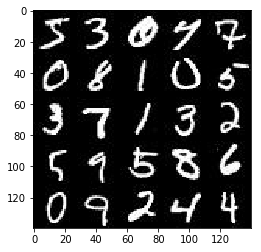

In [12]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

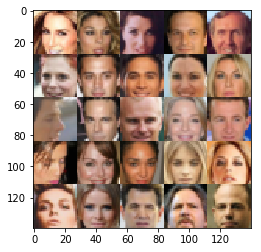

In [13]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [14]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0


C:\Users\hnie\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:14: UserWarning: No GPU found. Please use a GPU to train your neural network.
  


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [15]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_real = tf.placeholder(tf.float32, [None, image_width, image_height, image_channels])
    input_z = tf.placeholder(tf.float32, [None, z_dim])
    learning_rate = tf.placeholder(tf.float32)
    return input_real, input_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [17]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        alpha = 0.2
        dropout = 0.5
        
        #input layer is 28*28*3 or 28*28*1
        noise = tf.random_normal(shape=tf.shape(images), mean=0.0, stddev=0.2, dtype=tf.float32)
        images = images + noise
        
        x1 = tf.layers.conv2d(images, 64, 5, strides=1 ,padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        relu1 = tf.maximum(alpha * x1, x1)
        #now is 28*28*64
        
        x2 = tf.layers.conv2d(relu1, 64, 5, strides=1 ,padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        #now is also 28*28*64
        
        x3 = tf.layers.conv2d(relu2, 64, 5, strides=2 ,padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)      
        drop3 = tf.nn.dropout(relu3, dropout)
        #now is 14*14*64
        
        x4 = tf.layers.conv2d(drop3, 128, 5, strides=1, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        bn4 = tf.layers.batch_normalization(x4, training=True)
        relu4 = tf.maximum(alpha * bn4, bn4)
        #now is 14*14*128
        
        x5 = tf.layers.conv2d(relu4, 128, 5, strides=1, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        bn5 = tf.layers.batch_normalization(x5, training=True)
        relu5 = tf.maximum(alpha * bn5, bn5)        
        #now is also 14*14*128
        
        x6 = tf.layers.conv2d(relu5, 128, 5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        bn6 = tf.layers.batch_normalization(x6, training=True)
        relu6 = tf.maximum(alpha * bn6, bn6) 
        drop6 = tf.nn.dropout(relu6, dropout)
        #now is 7*7*128        
        
        x7 = tf.layers.conv2d(drop6, 256, 5, strides=1, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        bn7 = tf.layers.batch_normalization(x7, training=True)
        relu7 = tf.maximum(alpha * bn7, bn7)
        #now is 7*7*256
        
        x8 = tf.layers.conv2d(relu7, 256, 5, strides=1, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        bn8 = tf.layers.batch_normalization(x8, training=True)
        relu8 = tf.maximum(alpha * bn8, bn8)        
        #now is also 7*7*256
        
        x9 = tf.layers.conv2d(relu8, 256, 5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        bn9 = tf.layers.batch_normalization(x9, training=True)
        relu9 = tf.maximum(alpha * bn9, bn9)                 
        drop9 = tf.nn.dropout(relu9, dropout)
        #now is 4*4*256
        
        flat = tf.reshape(drop9, [-1, 4*4*256])
        logits = tf.layers.dense(flat, 1, kernel_initializer=tf.contrib.layers.xavier_initializer())
        out = tf.nn.sigmoid(logits)
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [18]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse=not is_train):
        alpha = 0.2
        dropout = 0.5
        
        #first fully connected
        x1 = tf.layers.dense(z, 7*7*512, kernel_initializer=tf.contrib.layers.xavier_initializer())
        x1 = tf.layers.batch_normalization(x1, training=is_train)
       
        #reshape
        x1 = tf.reshape(x1, [-1, 7, 7, 512])
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        x1 = tf.nn.dropout(x1, dropout)
        #now is 7*7*512

        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        #now is 14*14*256
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        #now is 28*28*128
        
        #output layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=1, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        out = tf.nn.tanh(logits)
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [37]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real) * 0.9))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    d_loss = d_loss_real + d_loss_fake
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [38]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [39]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [40]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    input_real, input_z, _ = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    global_step = tf.Variable(0, trainable=False)
    d_learning_rate = tf.train.exponential_decay(learning_rate[0], global_step, 500, 0.96, staircase=True)
    g_learning_rate = tf.train.exponential_decay(learning_rate[1], global_step, 500, 0.96, staircase=True)
    d_train_opt, _ = model_opt(d_loss, g_loss, d_learning_rate, beta1)
    _, g_train_opt = model_opt(d_loss, g_loss, g_learning_rate, beta1)
    
    saver = tf.train.Saver()
    
    #samples, losses = [], []
    steps = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                # Sample random noise for G
                batch_z = np.random.uniform(-1.0, 1.0, size=[batch_size, z_dim])
                batch_images = batch_images * 2
                #Run optimizers
                _ = sess.run(d_train_opt, feed_dict={input_real: batch_images, input_z: batch_z})
                _ = sess.run(g_train_opt, feed_dict={input_real: batch_images, input_z: batch_z})
                
                if(steps % 10 == 0):
                    #Get and print losses
                    train_loss_d = sess.run(d_loss, feed_dict={input_real: batch_images, input_z: batch_z})
                    train_loss_g = sess.run(g_loss, feed_dict={input_z: batch_z})
                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                         "Discriminator loss: {:.4f}".format(train_loss_d),
                         "Generator loss: {:.4f}".format(train_loss_g))
                    #Save losses
                    #losses.append((train_loss_d, train_loss_g))
                
                if(steps % 100 == 0):
                    show_generator_output(sess, 25, input_z, data_shape[3], data_image_mode)
            
        saver.save(sess, './checkpoints/generator.ckpt')
        print("Complete training!")

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator loss: 1.5028 Generator loss: 1.0506
Epoch 1/2... Discriminator loss: 1.0637 Generator loss: 1.5724
Epoch 1/2... Discriminator loss: 2.5635 Generator loss: 0.9360
Epoch 1/2... Discriminator loss: 1.4680 Generator loss: 1.3563
Epoch 1/2... Discriminator loss: 2.4165 Generator loss: 0.7679
Epoch 1/2... Discriminator loss: 1.7436 Generator loss: 0.9963
Epoch 1/2... Discriminator loss: 2.7325 Generator loss: 0.8872
Epoch 1/2... Discriminator loss: 1.3562 Generator loss: 1.1045
Epoch 1/2... Discriminator loss: 1.9211 Generator loss: 0.8257
Epoch 1/2... Discriminator loss: 1.5907 Generator loss: 1.0901


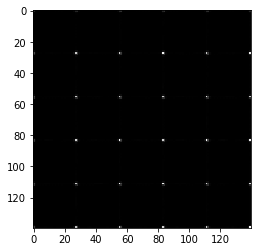

Epoch 1/2... Discriminator loss: 1.4551 Generator loss: 1.1106
Epoch 1/2... Discriminator loss: 1.7623 Generator loss: 0.8687
Epoch 1/2... Discriminator loss: 1.6103 Generator loss: 0.6974
Epoch 1/2... Discriminator loss: 1.5983 Generator loss: 1.0726
Epoch 1/2... Discriminator loss: 1.7856 Generator loss: 0.7557
Epoch 1/2... Discriminator loss: 1.6647 Generator loss: 1.0314
Epoch 1/2... Discriminator loss: 1.3893 Generator loss: 0.8296
Epoch 1/2... Discriminator loss: 1.6346 Generator loss: 1.2033
Epoch 1/2... Discriminator loss: 1.6702 Generator loss: 0.8509
Epoch 1/2... Discriminator loss: 1.5532 Generator loss: 0.9356


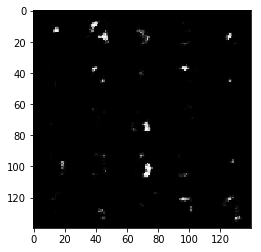

Epoch 1/2... Discriminator loss: 1.4818 Generator loss: 1.0998
Epoch 1/2... Discriminator loss: 1.5980 Generator loss: 0.9150
Epoch 1/2... Discriminator loss: 1.4391 Generator loss: 0.7722
Epoch 1/2... Discriminator loss: 1.5851 Generator loss: 0.9042
Epoch 1/2... Discriminator loss: 1.5852 Generator loss: 1.2464
Epoch 1/2... Discriminator loss: 1.7613 Generator loss: 0.8875
Epoch 1/2... Discriminator loss: 1.7644 Generator loss: 0.9431
Epoch 1/2... Discriminator loss: 1.3701 Generator loss: 0.9610
Epoch 1/2... Discriminator loss: 1.3461 Generator loss: 0.9871
Epoch 1/2... Discriminator loss: 1.5416 Generator loss: 1.0344


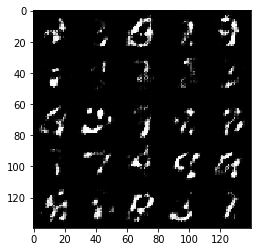

Epoch 1/2... Discriminator loss: 1.5339 Generator loss: 0.8313
Epoch 1/2... Discriminator loss: 1.7249 Generator loss: 1.0521
Epoch 1/2... Discriminator loss: 1.4220 Generator loss: 0.9744
Epoch 1/2... Discriminator loss: 1.6427 Generator loss: 0.9387
Epoch 1/2... Discriminator loss: 1.8091 Generator loss: 0.8273
Epoch 1/2... Discriminator loss: 1.4223 Generator loss: 0.8091
Epoch 1/2... Discriminator loss: 1.6837 Generator loss: 0.8095
Epoch 1/2... Discriminator loss: 1.3963 Generator loss: 1.0434
Epoch 1/2... Discriminator loss: 1.5101 Generator loss: 1.0537
Epoch 1/2... Discriminator loss: 1.4303 Generator loss: 1.3474


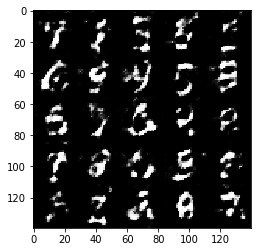

Epoch 1/2... Discriminator loss: 1.4887 Generator loss: 0.9086
Epoch 1/2... Discriminator loss: 1.2447 Generator loss: 0.9018
Epoch 1/2... Discriminator loss: 1.4739 Generator loss: 0.9928
Epoch 1/2... Discriminator loss: 1.4445 Generator loss: 1.0791
Epoch 1/2... Discriminator loss: 1.4616 Generator loss: 0.8980
Epoch 1/2... Discriminator loss: 1.4615 Generator loss: 1.0815
Epoch 1/2... Discriminator loss: 1.4628 Generator loss: 0.8780
Epoch 1/2... Discriminator loss: 1.3273 Generator loss: 0.9422
Epoch 1/2... Discriminator loss: 1.4491 Generator loss: 0.7632
Epoch 1/2... Discriminator loss: 1.3047 Generator loss: 0.8399


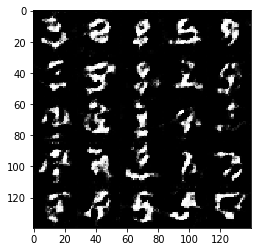

Epoch 1/2... Discriminator loss: 1.5912 Generator loss: 0.9720
Epoch 1/2... Discriminator loss: 1.2670 Generator loss: 0.6984
Epoch 1/2... Discriminator loss: 1.4310 Generator loss: 0.8762
Epoch 1/2... Discriminator loss: 1.6475 Generator loss: 0.9014
Epoch 1/2... Discriminator loss: 1.4168 Generator loss: 0.9963
Epoch 1/2... Discriminator loss: 1.5266 Generator loss: 1.1011
Epoch 1/2... Discriminator loss: 1.6603 Generator loss: 1.0780
Epoch 1/2... Discriminator loss: 1.5104 Generator loss: 1.0364
Epoch 1/2... Discriminator loss: 1.2579 Generator loss: 1.0630
Epoch 1/2... Discriminator loss: 1.6277 Generator loss: 0.9039


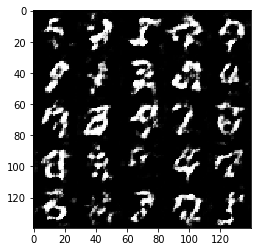

Epoch 1/2... Discriminator loss: 1.3126 Generator loss: 0.8720
Epoch 1/2... Discriminator loss: 1.3627 Generator loss: 0.9205
Epoch 1/2... Discriminator loss: 1.4894 Generator loss: 0.8821
Epoch 1/2... Discriminator loss: 1.3466 Generator loss: 1.0503
Epoch 1/2... Discriminator loss: 1.3533 Generator loss: 0.8751
Epoch 1/2... Discriminator loss: 1.5200 Generator loss: 0.8809
Epoch 1/2... Discriminator loss: 1.3320 Generator loss: 0.8977
Epoch 1/2... Discriminator loss: 1.5813 Generator loss: 0.8547
Epoch 1/2... Discriminator loss: 1.5147 Generator loss: 0.9928
Epoch 1/2... Discriminator loss: 1.2870 Generator loss: 0.9780


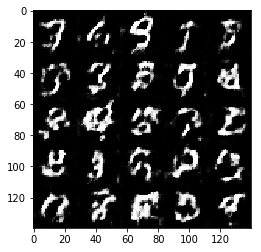

Epoch 1/2... Discriminator loss: 1.5832 Generator loss: 0.9850
Epoch 1/2... Discriminator loss: 1.3945 Generator loss: 0.8901
Epoch 1/2... Discriminator loss: 1.4302 Generator loss: 0.9548
Epoch 1/2... Discriminator loss: 1.3539 Generator loss: 1.0128
Epoch 1/2... Discriminator loss: 1.4534 Generator loss: 0.9598
Epoch 1/2... Discriminator loss: 1.3529 Generator loss: 1.0129
Epoch 1/2... Discriminator loss: 1.3930 Generator loss: 1.1428
Epoch 1/2... Discriminator loss: 1.3127 Generator loss: 1.1175
Epoch 1/2... Discriminator loss: 1.3770 Generator loss: 0.9786
Epoch 1/2... Discriminator loss: 1.3412 Generator loss: 1.0483


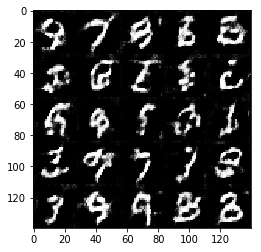

Epoch 1/2... Discriminator loss: 1.4913 Generator loss: 0.8244
Epoch 1/2... Discriminator loss: 1.3367 Generator loss: 0.8788
Epoch 1/2... Discriminator loss: 1.4102 Generator loss: 0.9920
Epoch 1/2... Discriminator loss: 1.2532 Generator loss: 0.7959
Epoch 1/2... Discriminator loss: 1.4833 Generator loss: 0.9092
Epoch 1/2... Discriminator loss: 1.4638 Generator loss: 0.8909
Epoch 1/2... Discriminator loss: 1.4528 Generator loss: 0.9036
Epoch 1/2... Discriminator loss: 1.3599 Generator loss: 0.9922
Epoch 1/2... Discriminator loss: 1.3932 Generator loss: 1.1376
Epoch 1/2... Discriminator loss: 1.3919 Generator loss: 0.8090


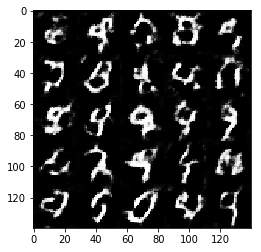

Epoch 1/2... Discriminator loss: 1.3969 Generator loss: 0.8617
Epoch 1/2... Discriminator loss: 1.3909 Generator loss: 0.8847
Epoch 1/2... Discriminator loss: 1.3057 Generator loss: 0.9645
Epoch 1/2... Discriminator loss: 1.3680 Generator loss: 0.9749
Epoch 1/2... Discriminator loss: 1.3017 Generator loss: 0.8952
Epoch 1/2... Discriminator loss: 1.3328 Generator loss: 0.9049
Epoch 1/2... Discriminator loss: 1.3171 Generator loss: 0.9816
Epoch 1/2... Discriminator loss: 1.3030 Generator loss: 0.9793
Epoch 1/2... Discriminator loss: 1.4871 Generator loss: 1.0425
Epoch 1/2... Discriminator loss: 1.3505 Generator loss: 0.9199


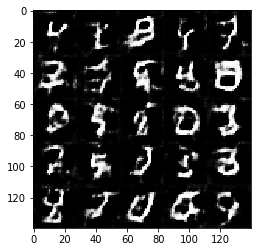

Epoch 1/2... Discriminator loss: 1.3436 Generator loss: 0.8141
Epoch 1/2... Discriminator loss: 1.4235 Generator loss: 0.8179
Epoch 1/2... Discriminator loss: 1.3600 Generator loss: 0.9958
Epoch 1/2... Discriminator loss: 1.4008 Generator loss: 0.8833
Epoch 1/2... Discriminator loss: 1.3260 Generator loss: 1.0155
Epoch 1/2... Discriminator loss: 1.2916 Generator loss: 0.9466
Epoch 1/2... Discriminator loss: 1.5068 Generator loss: 0.7085
Epoch 1/2... Discriminator loss: 1.4186 Generator loss: 0.8386
Epoch 1/2... Discriminator loss: 1.2679 Generator loss: 0.9528
Epoch 1/2... Discriminator loss: 1.3716 Generator loss: 0.8215


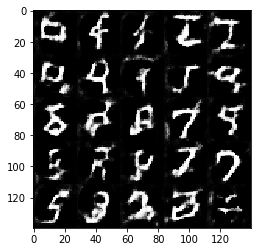

Epoch 1/2... Discriminator loss: 1.2555 Generator loss: 0.9017
Epoch 1/2... Discriminator loss: 1.4008 Generator loss: 0.9288
Epoch 1/2... Discriminator loss: 1.3439 Generator loss: 0.9300
Epoch 1/2... Discriminator loss: 1.4080 Generator loss: 0.9043
Epoch 1/2... Discriminator loss: 1.5095 Generator loss: 0.9876
Epoch 1/2... Discriminator loss: 1.3533 Generator loss: 0.9914
Epoch 1/2... Discriminator loss: 1.3836 Generator loss: 0.8036
Epoch 1/2... Discriminator loss: 1.3807 Generator loss: 0.8419
Epoch 1/2... Discriminator loss: 1.2003 Generator loss: 1.0123
Epoch 1/2... Discriminator loss: 1.4505 Generator loss: 0.8354


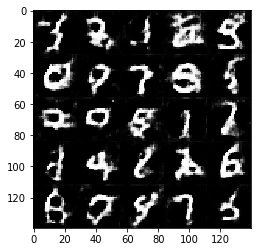

Epoch 1/2... Discriminator loss: 1.4452 Generator loss: 0.8742
Epoch 1/2... Discriminator loss: 1.3765 Generator loss: 0.8293
Epoch 1/2... Discriminator loss: 1.5291 Generator loss: 0.9313
Epoch 1/2... Discriminator loss: 1.3054 Generator loss: 0.9323
Epoch 1/2... Discriminator loss: 1.4390 Generator loss: 0.7305
Epoch 1/2... Discriminator loss: 1.4558 Generator loss: 0.8565
Epoch 1/2... Discriminator loss: 1.3303 Generator loss: 0.7544
Epoch 1/2... Discriminator loss: 1.4408 Generator loss: 0.8847
Epoch 1/2... Discriminator loss: 1.3250 Generator loss: 1.1452
Epoch 1/2... Discriminator loss: 1.3050 Generator loss: 0.9621


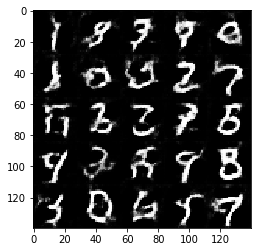

Epoch 1/2... Discriminator loss: 1.4538 Generator loss: 0.9035
Epoch 1/2... Discriminator loss: 1.3419 Generator loss: 1.0114
Epoch 1/2... Discriminator loss: 1.3809 Generator loss: 0.8817
Epoch 1/2... Discriminator loss: 1.3092 Generator loss: 0.9195
Epoch 1/2... Discriminator loss: 1.2489 Generator loss: 0.8958
Epoch 1/2... Discriminator loss: 1.4341 Generator loss: 0.9549
Epoch 1/2... Discriminator loss: 1.3679 Generator loss: 0.9078
Epoch 1/2... Discriminator loss: 1.2645 Generator loss: 0.8683
Epoch 1/2... Discriminator loss: 1.3510 Generator loss: 0.8682
Epoch 1/2... Discriminator loss: 1.3791 Generator loss: 0.7815


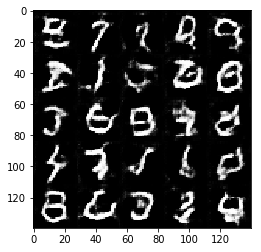

Epoch 1/2... Discriminator loss: 1.3545 Generator loss: 0.9000
Epoch 1/2... Discriminator loss: 1.3629 Generator loss: 0.8425
Epoch 1/2... Discriminator loss: 1.3005 Generator loss: 0.9309
Epoch 1/2... Discriminator loss: 1.3419 Generator loss: 1.0740
Epoch 1/2... Discriminator loss: 1.4956 Generator loss: 0.9258
Epoch 1/2... Discriminator loss: 1.3517 Generator loss: 0.9235
Epoch 1/2... Discriminator loss: 1.3326 Generator loss: 0.9141
Epoch 1/2... Discriminator loss: 1.3520 Generator loss: 0.9084
Epoch 1/2... Discriminator loss: 1.2836 Generator loss: 0.9055
Epoch 1/2... Discriminator loss: 1.3630 Generator loss: 0.9102


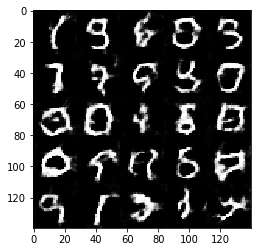

Epoch 1/2... Discriminator loss: 1.3859 Generator loss: 0.6500
Epoch 1/2... Discriminator loss: 1.2780 Generator loss: 1.0591
Epoch 1/2... Discriminator loss: 1.5095 Generator loss: 0.8024
Epoch 1/2... Discriminator loss: 1.3326 Generator loss: 0.8675
Epoch 1/2... Discriminator loss: 1.3556 Generator loss: 0.9357
Epoch 1/2... Discriminator loss: 1.2806 Generator loss: 1.0022
Epoch 1/2... Discriminator loss: 1.4459 Generator loss: 0.9024
Epoch 1/2... Discriminator loss: 1.2393 Generator loss: 0.9458
Epoch 1/2... Discriminator loss: 1.3135 Generator loss: 0.9211
Epoch 1/2... Discriminator loss: 1.4022 Generator loss: 0.7779


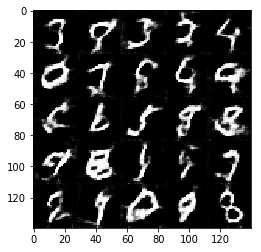

Epoch 1/2... Discriminator loss: 1.5470 Generator loss: 1.0085
Epoch 1/2... Discriminator loss: 1.3657 Generator loss: 0.8669
Epoch 1/2... Discriminator loss: 1.3572 Generator loss: 0.8284
Epoch 1/2... Discriminator loss: 1.3407 Generator loss: 0.9516
Epoch 1/2... Discriminator loss: 1.2139 Generator loss: 0.9940
Epoch 1/2... Discriminator loss: 1.3925 Generator loss: 0.8973
Epoch 1/2... Discriminator loss: 1.4191 Generator loss: 1.1191
Epoch 1/2... Discriminator loss: 1.5333 Generator loss: 0.8061
Epoch 1/2... Discriminator loss: 1.3580 Generator loss: 0.8560
Epoch 1/2... Discriminator loss: 1.3071 Generator loss: 0.8963


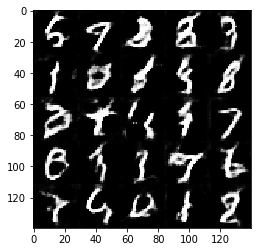

Epoch 1/2... Discriminator loss: 1.3120 Generator loss: 0.8929
Epoch 1/2... Discriminator loss: 1.4566 Generator loss: 0.8509
Epoch 1/2... Discriminator loss: 1.3084 Generator loss: 0.9551
Epoch 1/2... Discriminator loss: 1.4104 Generator loss: 0.8920
Epoch 1/2... Discriminator loss: 1.3973 Generator loss: 0.8985
Epoch 1/2... Discriminator loss: 1.3164 Generator loss: 0.8594
Epoch 1/2... Discriminator loss: 1.3528 Generator loss: 0.9961
Epoch 1/2... Discriminator loss: 1.4339 Generator loss: 0.8218
Epoch 1/2... Discriminator loss: 1.3316 Generator loss: 0.9604
Epoch 1/2... Discriminator loss: 1.3949 Generator loss: 1.0050


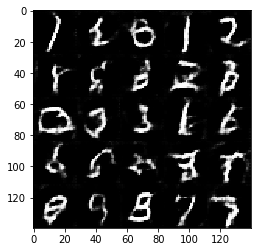

Epoch 1/2... Discriminator loss: 1.3435 Generator loss: 0.9236
Epoch 1/2... Discriminator loss: 1.3763 Generator loss: 0.7953
Epoch 1/2... Discriminator loss: 1.3452 Generator loss: 0.9309
Epoch 1/2... Discriminator loss: 1.3867 Generator loss: 0.8073
Epoch 1/2... Discriminator loss: 1.3715 Generator loss: 1.0206
Epoch 1/2... Discriminator loss: 1.2816 Generator loss: 1.0303
Epoch 1/2... Discriminator loss: 1.4506 Generator loss: 0.8097
Epoch 2/2... Discriminator loss: 1.3348 Generator loss: 0.9348
Epoch 2/2... Discriminator loss: 1.3376 Generator loss: 0.8136
Epoch 2/2... Discriminator loss: 1.5426 Generator loss: 0.9352


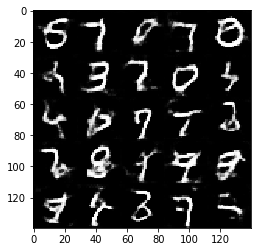

Epoch 2/2... Discriminator loss: 1.4885 Generator loss: 0.8701
Epoch 2/2... Discriminator loss: 1.2642 Generator loss: 0.9298
Epoch 2/2... Discriminator loss: 1.3374 Generator loss: 0.8162
Epoch 2/2... Discriminator loss: 1.2580 Generator loss: 0.8176
Epoch 2/2... Discriminator loss: 1.3281 Generator loss: 0.9305
Epoch 2/2... Discriminator loss: 1.3188 Generator loss: 0.9255
Epoch 2/2... Discriminator loss: 1.3419 Generator loss: 0.9092
Epoch 2/2... Discriminator loss: 1.2804 Generator loss: 0.9651
Epoch 2/2... Discriminator loss: 1.3994 Generator loss: 0.9044
Epoch 2/2... Discriminator loss: 1.3764 Generator loss: 0.8376


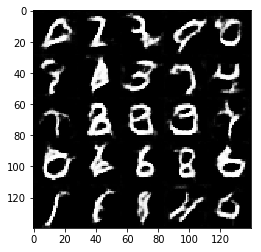

Epoch 2/2... Discriminator loss: 1.3714 Generator loss: 0.8338
Epoch 2/2... Discriminator loss: 1.2153 Generator loss: 0.9224
Epoch 2/2... Discriminator loss: 1.3971 Generator loss: 0.8366
Epoch 2/2... Discriminator loss: 1.2824 Generator loss: 1.0159
Epoch 2/2... Discriminator loss: 1.4245 Generator loss: 0.9732
Epoch 2/2... Discriminator loss: 1.2686 Generator loss: 0.8085
Epoch 2/2... Discriminator loss: 1.2478 Generator loss: 0.8588
Epoch 2/2... Discriminator loss: 1.3888 Generator loss: 0.9056
Epoch 2/2... Discriminator loss: 1.3810 Generator loss: 0.8714
Epoch 2/2... Discriminator loss: 1.3021 Generator loss: 0.9124


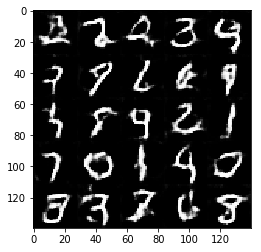

Epoch 2/2... Discriminator loss: 1.3467 Generator loss: 0.9734
Epoch 2/2... Discriminator loss: 1.3149 Generator loss: 0.8879
Epoch 2/2... Discriminator loss: 1.3437 Generator loss: 0.9223
Epoch 2/2... Discriminator loss: 1.2145 Generator loss: 1.0275
Epoch 2/2... Discriminator loss: 1.3128 Generator loss: 0.9114
Epoch 2/2... Discriminator loss: 1.2527 Generator loss: 0.9172
Epoch 2/2... Discriminator loss: 1.3412 Generator loss: 0.8771
Epoch 2/2... Discriminator loss: 1.2908 Generator loss: 1.1094
Epoch 2/2... Discriminator loss: 1.4561 Generator loss: 0.8669
Epoch 2/2... Discriminator loss: 1.4383 Generator loss: 0.8343


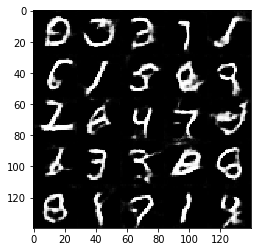

Epoch 2/2... Discriminator loss: 1.2847 Generator loss: 0.8646
Epoch 2/2... Discriminator loss: 1.2500 Generator loss: 0.8117
Epoch 2/2... Discriminator loss: 1.2822 Generator loss: 0.9533
Epoch 2/2... Discriminator loss: 1.2944 Generator loss: 0.9952
Epoch 2/2... Discriminator loss: 1.2280 Generator loss: 0.9665
Epoch 2/2... Discriminator loss: 1.2137 Generator loss: 0.9769
Epoch 2/2... Discriminator loss: 1.2706 Generator loss: 0.8796
Epoch 2/2... Discriminator loss: 1.3859 Generator loss: 0.9797
Epoch 2/2... Discriminator loss: 1.2795 Generator loss: 0.8643
Epoch 2/2... Discriminator loss: 1.4224 Generator loss: 0.9959


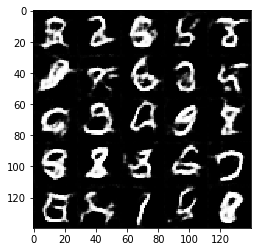

Epoch 2/2... Discriminator loss: 1.3219 Generator loss: 0.9233
Epoch 2/2... Discriminator loss: 1.2849 Generator loss: 0.9355
Epoch 2/2... Discriminator loss: 1.3266 Generator loss: 0.9248
Epoch 2/2... Discriminator loss: 1.4244 Generator loss: 0.7899
Epoch 2/2... Discriminator loss: 1.3223 Generator loss: 0.9509
Epoch 2/2... Discriminator loss: 1.3566 Generator loss: 0.9593
Epoch 2/2... Discriminator loss: 1.4417 Generator loss: 0.8996
Epoch 2/2... Discriminator loss: 1.3169 Generator loss: 0.7760
Epoch 2/2... Discriminator loss: 1.3068 Generator loss: 0.8514
Epoch 2/2... Discriminator loss: 1.3853 Generator loss: 0.8252


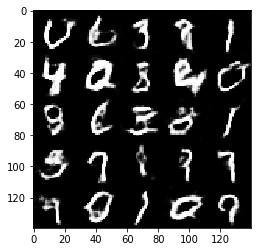

Epoch 2/2... Discriminator loss: 1.3305 Generator loss: 0.7711
Epoch 2/2... Discriminator loss: 1.3690 Generator loss: 0.8765
Epoch 2/2... Discriminator loss: 1.3240 Generator loss: 0.8842
Epoch 2/2... Discriminator loss: 1.3939 Generator loss: 0.9961
Epoch 2/2... Discriminator loss: 1.3523 Generator loss: 0.9030
Epoch 2/2... Discriminator loss: 1.2980 Generator loss: 1.0280
Epoch 2/2... Discriminator loss: 1.3500 Generator loss: 1.0550
Epoch 2/2... Discriminator loss: 1.3358 Generator loss: 0.8363
Epoch 2/2... Discriminator loss: 1.3711 Generator loss: 0.8878
Epoch 2/2... Discriminator loss: 1.3809 Generator loss: 0.9791


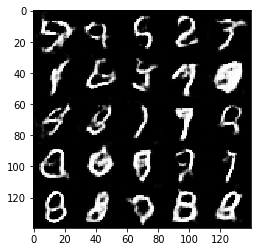

Epoch 2/2... Discriminator loss: 1.3679 Generator loss: 0.7755
Epoch 2/2... Discriminator loss: 1.3496 Generator loss: 0.8414
Epoch 2/2... Discriminator loss: 1.2199 Generator loss: 0.8203
Epoch 2/2... Discriminator loss: 1.3776 Generator loss: 0.9137
Epoch 2/2... Discriminator loss: 1.2484 Generator loss: 0.9081
Epoch 2/2... Discriminator loss: 1.2406 Generator loss: 1.0726
Epoch 2/2... Discriminator loss: 1.3430 Generator loss: 0.9012
Epoch 2/2... Discriminator loss: 1.2670 Generator loss: 1.0383
Epoch 2/2... Discriminator loss: 1.3539 Generator loss: 0.8433
Epoch 2/2... Discriminator loss: 1.2974 Generator loss: 0.8887


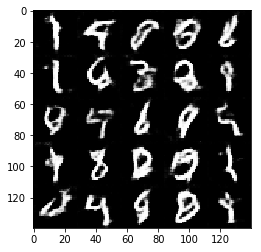

Epoch 2/2... Discriminator loss: 1.2072 Generator loss: 0.8422
Epoch 2/2... Discriminator loss: 1.4026 Generator loss: 0.9129
Epoch 2/2... Discriminator loss: 1.2758 Generator loss: 1.0018
Epoch 2/2... Discriminator loss: 1.3872 Generator loss: 0.8476
Epoch 2/2... Discriminator loss: 1.1385 Generator loss: 0.8315
Epoch 2/2... Discriminator loss: 1.2735 Generator loss: 0.7986
Epoch 2/2... Discriminator loss: 1.4604 Generator loss: 0.9072
Epoch 2/2... Discriminator loss: 1.2839 Generator loss: 0.8961
Epoch 2/2... Discriminator loss: 1.3197 Generator loss: 1.0431
Epoch 2/2... Discriminator loss: 1.2935 Generator loss: 0.9731


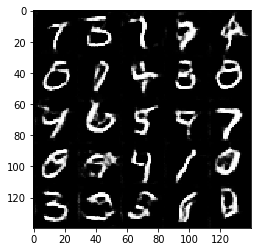

Epoch 2/2... Discriminator loss: 1.3124 Generator loss: 0.9607
Epoch 2/2... Discriminator loss: 1.4256 Generator loss: 0.9536
Epoch 2/2... Discriminator loss: 1.2499 Generator loss: 0.8978
Epoch 2/2... Discriminator loss: 1.3913 Generator loss: 0.8715
Epoch 2/2... Discriminator loss: 1.3155 Generator loss: 0.9098
Epoch 2/2... Discriminator loss: 1.3462 Generator loss: 0.7606
Epoch 2/2... Discriminator loss: 1.3320 Generator loss: 0.9631
Epoch 2/2... Discriminator loss: 1.3402 Generator loss: 0.9528
Epoch 2/2... Discriminator loss: 1.3016 Generator loss: 0.7839
Epoch 2/2... Discriminator loss: 1.2587 Generator loss: 1.0838


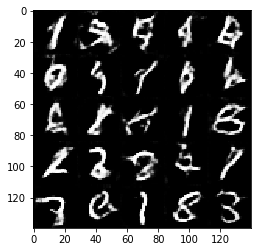

Epoch 2/2... Discriminator loss: 1.2269 Generator loss: 1.0906
Epoch 2/2... Discriminator loss: 1.3921 Generator loss: 0.8183
Epoch 2/2... Discriminator loss: 1.2646 Generator loss: 0.9276
Epoch 2/2... Discriminator loss: 1.1929 Generator loss: 0.9011
Epoch 2/2... Discriminator loss: 1.2874 Generator loss: 0.9162
Epoch 2/2... Discriminator loss: 1.3370 Generator loss: 0.9275
Epoch 2/2... Discriminator loss: 1.3431 Generator loss: 0.9243
Epoch 2/2... Discriminator loss: 1.3015 Generator loss: 0.8289
Epoch 2/2... Discriminator loss: 1.4735 Generator loss: 0.9900
Epoch 2/2... Discriminator loss: 1.4220 Generator loss: 1.1058


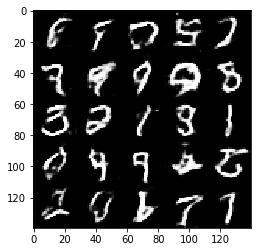

Epoch 2/2... Discriminator loss: 1.2658 Generator loss: 0.8443
Epoch 2/2... Discriminator loss: 1.3839 Generator loss: 0.9212
Epoch 2/2... Discriminator loss: 1.5144 Generator loss: 0.8882
Epoch 2/2... Discriminator loss: 1.3360 Generator loss: 0.8395
Epoch 2/2... Discriminator loss: 1.3745 Generator loss: 0.9087
Epoch 2/2... Discriminator loss: 1.3447 Generator loss: 0.9200
Epoch 2/2... Discriminator loss: 1.2902 Generator loss: 0.9589
Epoch 2/2... Discriminator loss: 1.3008 Generator loss: 0.9291
Epoch 2/2... Discriminator loss: 1.2236 Generator loss: 0.9243
Epoch 2/2... Discriminator loss: 1.3842 Generator loss: 0.8328


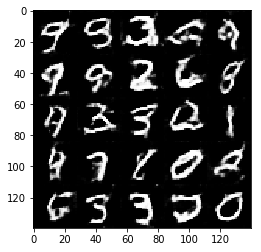

Epoch 2/2... Discriminator loss: 1.3907 Generator loss: 0.7073
Epoch 2/2... Discriminator loss: 1.3445 Generator loss: 0.9623
Epoch 2/2... Discriminator loss: 1.3189 Generator loss: 0.8494
Epoch 2/2... Discriminator loss: 1.3358 Generator loss: 0.8221
Epoch 2/2... Discriminator loss: 1.2634 Generator loss: 0.9450
Epoch 2/2... Discriminator loss: 1.3944 Generator loss: 0.6958
Epoch 2/2... Discriminator loss: 1.2484 Generator loss: 0.8963
Epoch 2/2... Discriminator loss: 1.2680 Generator loss: 0.7536
Epoch 2/2... Discriminator loss: 1.2932 Generator loss: 0.9763
Epoch 2/2... Discriminator loss: 1.3606 Generator loss: 0.9381


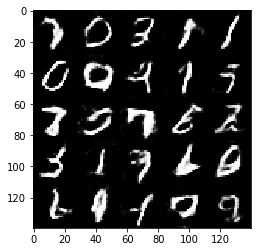

Epoch 2/2... Discriminator loss: 1.4486 Generator loss: 0.8534
Epoch 2/2... Discriminator loss: 1.3340 Generator loss: 0.8800
Epoch 2/2... Discriminator loss: 1.2814 Generator loss: 0.9649
Epoch 2/2... Discriminator loss: 1.3823 Generator loss: 0.8328
Epoch 2/2... Discriminator loss: 1.3710 Generator loss: 0.7150
Epoch 2/2... Discriminator loss: 1.5508 Generator loss: 0.9747
Epoch 2/2... Discriminator loss: 1.3625 Generator loss: 0.8323
Epoch 2/2... Discriminator loss: 1.3346 Generator loss: 0.9554
Epoch 2/2... Discriminator loss: 1.3047 Generator loss: 0.9770
Epoch 2/2... Discriminator loss: 1.2978 Generator loss: 0.8055


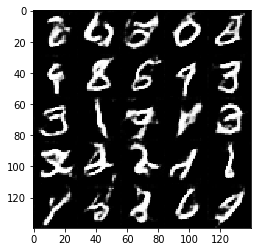

Epoch 2/2... Discriminator loss: 1.3496 Generator loss: 0.9198
Epoch 2/2... Discriminator loss: 1.3069 Generator loss: 1.1516
Epoch 2/2... Discriminator loss: 1.2761 Generator loss: 1.0026
Epoch 2/2... Discriminator loss: 1.2761 Generator loss: 0.9763
Epoch 2/2... Discriminator loss: 1.4647 Generator loss: 0.8850
Epoch 2/2... Discriminator loss: 1.2692 Generator loss: 0.9180
Epoch 2/2... Discriminator loss: 1.2568 Generator loss: 1.0433
Epoch 2/2... Discriminator loss: 1.2595 Generator loss: 0.8920
Epoch 2/2... Discriminator loss: 1.3226 Generator loss: 0.8396
Epoch 2/2... Discriminator loss: 1.4930 Generator loss: 0.9133


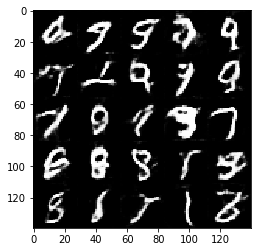

Epoch 2/2... Discriminator loss: 1.3888 Generator loss: 1.0568
Epoch 2/2... Discriminator loss: 1.2834 Generator loss: 0.9468
Epoch 2/2... Discriminator loss: 1.3288 Generator loss: 0.8903
Epoch 2/2... Discriminator loss: 1.3325 Generator loss: 0.8194
Epoch 2/2... Discriminator loss: 1.2968 Generator loss: 0.9704
Epoch 2/2... Discriminator loss: 1.3294 Generator loss: 0.9505
Epoch 2/2... Discriminator loss: 1.2339 Generator loss: 1.0527
Epoch 2/2... Discriminator loss: 1.3381 Generator loss: 0.9563
Epoch 2/2... Discriminator loss: 1.3117 Generator loss: 0.9821
Epoch 2/2... Discriminator loss: 1.2728 Generator loss: 0.9058


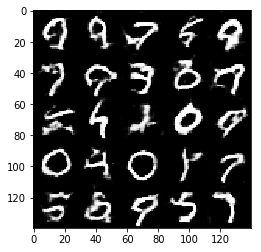

Epoch 2/2... Discriminator loss: 1.1876 Generator loss: 0.8304
Epoch 2/2... Discriminator loss: 1.4165 Generator loss: 0.9528
Epoch 2/2... Discriminator loss: 1.3551 Generator loss: 0.8986
Epoch 2/2... Discriminator loss: 1.1423 Generator loss: 1.0317
Epoch 2/2... Discriminator loss: 1.3897 Generator loss: 0.8613
Epoch 2/2... Discriminator loss: 1.3707 Generator loss: 0.8400
Epoch 2/2... Discriminator loss: 1.3012 Generator loss: 0.9029
Epoch 2/2... Discriminator loss: 1.5159 Generator loss: 0.9517
Epoch 2/2... Discriminator loss: 1.4425 Generator loss: 0.9055
Epoch 2/2... Discriminator loss: 1.2877 Generator loss: 0.7688


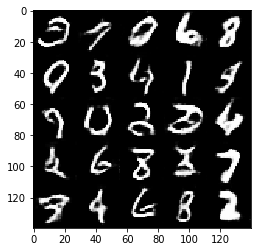

Epoch 2/2... Discriminator loss: 1.4820 Generator loss: 1.0308
Epoch 2/2... Discriminator loss: 1.2063 Generator loss: 0.9267
Epoch 2/2... Discriminator loss: 1.2940 Generator loss: 0.8709
Epoch 2/2... Discriminator loss: 1.4183 Generator loss: 0.8878
Epoch 2/2... Discriminator loss: 1.3453 Generator loss: 0.9378
Epoch 2/2... Discriminator loss: 1.3131 Generator loss: 0.9636
Epoch 2/2... Discriminator loss: 1.4353 Generator loss: 0.8051
Epoch 2/2... Discriminator loss: 1.2946 Generator loss: 0.7981
Epoch 2/2... Discriminator loss: 1.4703 Generator loss: 0.8381
Epoch 2/2... Discriminator loss: 1.2986 Generator loss: 0.8849


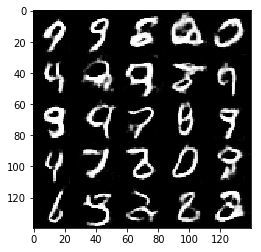

Epoch 2/2... Discriminator loss: 1.3287 Generator loss: 0.8567
Epoch 2/2... Discriminator loss: 1.2882 Generator loss: 0.8580
Epoch 2/2... Discriminator loss: 1.3198 Generator loss: 0.8679
Epoch 2/2... Discriminator loss: 1.4465 Generator loss: 0.8574
Epoch 2/2... Discriminator loss: 1.4124 Generator loss: 0.7579
Epoch 2/2... Discriminator loss: 1.2642 Generator loss: 0.8250
Epoch 2/2... Discriminator loss: 1.3230 Generator loss: 0.9686
Epoch 2/2... Discriminator loss: 1.3602 Generator loss: 1.0149
Epoch 2/2... Discriminator loss: 1.2358 Generator loss: 1.1414
Epoch 2/2... Discriminator loss: 1.4375 Generator loss: 0.9908


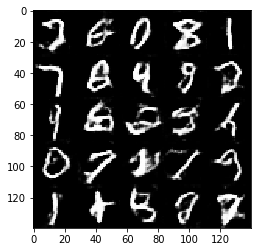

Epoch 2/2... Discriminator loss: 1.2882 Generator loss: 0.8953
Epoch 2/2... Discriminator loss: 1.3354 Generator loss: 1.0501
Epoch 2/2... Discriminator loss: 1.4027 Generator loss: 1.0161
Epoch 2/2... Discriminator loss: 1.2723 Generator loss: 0.8818
Epoch 2/2... Discriminator loss: 1.2436 Generator loss: 1.0413
Complete training!


In [42]:
batch_size = 32
z_dim = 100
learning_rate = (0.0002, 0.0004)
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator loss: 0.8951 Generator loss: 1.5107
Epoch 1/1... Discriminator loss: 0.9097 Generator loss: 1.4358
Epoch 1/1... Discriminator loss: 0.9861 Generator loss: 1.8128
Epoch 1/1... Discriminator loss: 0.9321 Generator loss: 1.7508
Epoch 1/1... Discriminator loss: 1.3278 Generator loss: 1.1463
Epoch 1/1... Discriminator loss: 1.1629 Generator loss: 1.0238
Epoch 1/1... Discriminator loss: 0.7586 Generator loss: 1.8301
Epoch 1/1... Discriminator loss: 0.8145 Generator loss: 2.0517
Epoch 1/1... Discriminator loss: 0.7835 Generator loss: 2.5353
Epoch 1/1... Discriminator loss: 0.6988 Generator loss: 3.3541


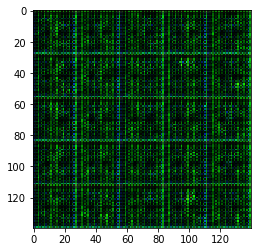

Epoch 1/1... Discriminator loss: 0.5847 Generator loss: 2.6185
Epoch 1/1... Discriminator loss: 0.7776 Generator loss: 1.9526
Epoch 1/1... Discriminator loss: 0.7382 Generator loss: 2.3401
Epoch 1/1... Discriminator loss: 0.6428 Generator loss: 3.0583
Epoch 1/1... Discriminator loss: 0.5385 Generator loss: 3.3943
Epoch 1/1... Discriminator loss: 0.5616 Generator loss: 4.0782
Epoch 1/1... Discriminator loss: 0.4826 Generator loss: 3.8480
Epoch 1/1... Discriminator loss: 0.4730 Generator loss: 4.1775
Epoch 1/1... Discriminator loss: 0.4472 Generator loss: 4.3886
Epoch 1/1... Discriminator loss: 0.4743 Generator loss: 4.3043


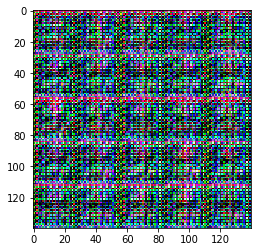

Epoch 1/1... Discriminator loss: 0.7849 Generator loss: 1.8746
Epoch 1/1... Discriminator loss: 0.9777 Generator loss: 1.5128
Epoch 1/1... Discriminator loss: 0.9184 Generator loss: 2.1989
Epoch 1/1... Discriminator loss: 0.7935 Generator loss: 1.5370
Epoch 1/1... Discriminator loss: 1.1106 Generator loss: 1.2498
Epoch 1/1... Discriminator loss: 1.4947 Generator loss: 1.1144
Epoch 1/1... Discriminator loss: 1.0716 Generator loss: 1.5696
Epoch 1/1... Discriminator loss: 1.1101 Generator loss: 2.0994
Epoch 1/1... Discriminator loss: 1.3850 Generator loss: 1.3164
Epoch 1/1... Discriminator loss: 1.5179 Generator loss: 1.7940


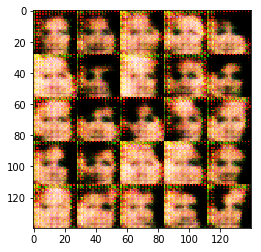

Epoch 1/1... Discriminator loss: 1.6888 Generator loss: 1.1219
Epoch 1/1... Discriminator loss: 1.5275 Generator loss: 0.9646
Epoch 1/1... Discriminator loss: 1.7471 Generator loss: 0.8597
Epoch 1/1... Discriminator loss: 1.1576 Generator loss: 1.7466
Epoch 1/1... Discriminator loss: 1.3964 Generator loss: 1.3420
Epoch 1/1... Discriminator loss: 0.8812 Generator loss: 2.3692
Epoch 1/1... Discriminator loss: 1.2576 Generator loss: 1.7037
Epoch 1/1... Discriminator loss: 1.3092 Generator loss: 1.4558
Epoch 1/1... Discriminator loss: 1.2626 Generator loss: 2.3933
Epoch 1/1... Discriminator loss: 1.0063 Generator loss: 1.7619


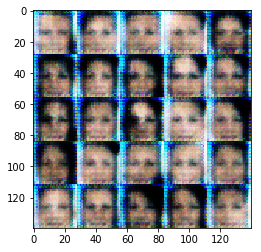

Epoch 1/1... Discriminator loss: 1.4253 Generator loss: 1.1280
Epoch 1/1... Discriminator loss: 1.0551 Generator loss: 3.2878
Epoch 1/1... Discriminator loss: 1.5386 Generator loss: 1.3510
Epoch 1/1... Discriminator loss: 1.1495 Generator loss: 2.1799
Epoch 1/1... Discriminator loss: 1.0298 Generator loss: 1.4464
Epoch 1/1... Discriminator loss: 1.2831 Generator loss: 0.9722
Epoch 1/1... Discriminator loss: 1.0373 Generator loss: 1.7853
Epoch 1/1... Discriminator loss: 1.9783 Generator loss: 0.8518
Epoch 1/1... Discriminator loss: 1.4062 Generator loss: 1.1170
Epoch 1/1... Discriminator loss: 1.6931 Generator loss: 0.8375


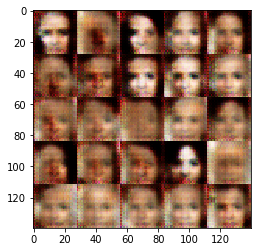

Epoch 1/1... Discriminator loss: 1.4931 Generator loss: 1.1932
Epoch 1/1... Discriminator loss: 1.4441 Generator loss: 1.0695
Epoch 1/1... Discriminator loss: 1.2522 Generator loss: 1.3288
Epoch 1/1... Discriminator loss: 1.2989 Generator loss: 1.3131
Epoch 1/1... Discriminator loss: 1.0014 Generator loss: 2.1058
Epoch 1/1... Discriminator loss: 1.2011 Generator loss: 0.8618
Epoch 1/1... Discriminator loss: 1.1517 Generator loss: 1.3573
Epoch 1/1... Discriminator loss: 1.5225 Generator loss: 0.6984
Epoch 1/1... Discriminator loss: 0.9806 Generator loss: 1.4034
Epoch 1/1... Discriminator loss: 1.6889 Generator loss: 0.9391


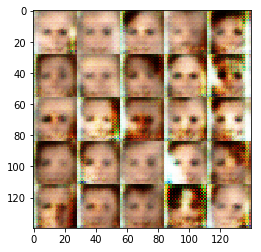

Epoch 1/1... Discriminator loss: 1.1555 Generator loss: 0.9882
Epoch 1/1... Discriminator loss: 1.4177 Generator loss: 1.5038
Epoch 1/1... Discriminator loss: 1.1170 Generator loss: 1.7381
Epoch 1/1... Discriminator loss: 1.6329 Generator loss: 0.7515
Epoch 1/1... Discriminator loss: 1.0932 Generator loss: 1.6145
Epoch 1/1... Discriminator loss: 1.3476 Generator loss: 1.7493
Epoch 1/1... Discriminator loss: 1.5230 Generator loss: 1.0507
Epoch 1/1... Discriminator loss: 1.4643 Generator loss: 0.7908
Epoch 1/1... Discriminator loss: 1.0171 Generator loss: 1.6651
Epoch 1/1... Discriminator loss: 1.5071 Generator loss: 0.9897


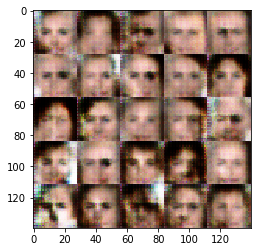

Epoch 1/1... Discriminator loss: 1.3403 Generator loss: 1.1049
Epoch 1/1... Discriminator loss: 1.6480 Generator loss: 0.6355
Epoch 1/1... Discriminator loss: 1.8914 Generator loss: 0.7451
Epoch 1/1... Discriminator loss: 1.4689 Generator loss: 0.8750
Epoch 1/1... Discriminator loss: 1.5823 Generator loss: 0.6910
Epoch 1/1... Discriminator loss: 1.5187 Generator loss: 1.1251
Epoch 1/1... Discriminator loss: 1.2838 Generator loss: 0.9896
Epoch 1/1... Discriminator loss: 1.3193 Generator loss: 0.6920
Epoch 1/1... Discriminator loss: 1.0635 Generator loss: 1.2617
Epoch 1/1... Discriminator loss: 1.5949 Generator loss: 1.2260


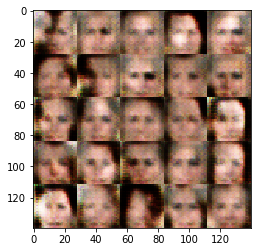

Epoch 1/1... Discriminator loss: 1.4151 Generator loss: 0.9860
Epoch 1/1... Discriminator loss: 1.6732 Generator loss: 0.8386
Epoch 1/1... Discriminator loss: 1.5015 Generator loss: 1.1764
Epoch 1/1... Discriminator loss: 1.2641 Generator loss: 1.3373
Epoch 1/1... Discriminator loss: 1.3770 Generator loss: 1.1199
Epoch 1/1... Discriminator loss: 1.6312 Generator loss: 1.0761
Epoch 1/1... Discriminator loss: 1.3321 Generator loss: 0.8061
Epoch 1/1... Discriminator loss: 1.6637 Generator loss: 1.0412
Epoch 1/1... Discriminator loss: 1.7587 Generator loss: 0.8189
Epoch 1/1... Discriminator loss: 1.4084 Generator loss: 0.8265


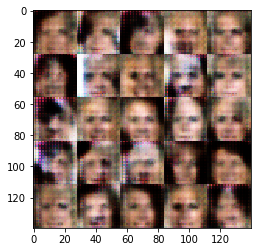

Epoch 1/1... Discriminator loss: 1.0882 Generator loss: 1.5418
Epoch 1/1... Discriminator loss: 1.5084 Generator loss: 0.8750
Epoch 1/1... Discriminator loss: 1.5725 Generator loss: 0.9298
Epoch 1/1... Discriminator loss: 1.3716 Generator loss: 1.5975
Epoch 1/1... Discriminator loss: 1.3649 Generator loss: 0.9430
Epoch 1/1... Discriminator loss: 1.5946 Generator loss: 0.8925
Epoch 1/1... Discriminator loss: 1.2951 Generator loss: 0.8002
Epoch 1/1... Discriminator loss: 1.2041 Generator loss: 1.4154
Epoch 1/1... Discriminator loss: 1.3911 Generator loss: 0.7884
Epoch 1/1... Discriminator loss: 1.5889 Generator loss: 0.9975


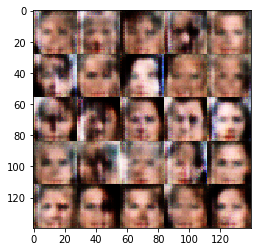

Epoch 1/1... Discriminator loss: 1.0869 Generator loss: 1.3103
Epoch 1/1... Discriminator loss: 0.9675 Generator loss: 1.5808
Epoch 1/1... Discriminator loss: 1.6654 Generator loss: 0.9350
Epoch 1/1... Discriminator loss: 1.4266 Generator loss: 0.7945
Epoch 1/1... Discriminator loss: 1.1025 Generator loss: 1.9802
Epoch 1/1... Discriminator loss: 1.5957 Generator loss: 0.8889
Epoch 1/1... Discriminator loss: 1.4433 Generator loss: 0.9612
Epoch 1/1... Discriminator loss: 1.0150 Generator loss: 0.8104
Epoch 1/1... Discriminator loss: 1.1212 Generator loss: 1.4882
Epoch 1/1... Discriminator loss: 1.6183 Generator loss: 0.8688


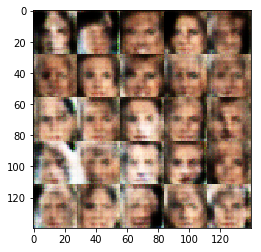

Epoch 1/1... Discriminator loss: 1.5734 Generator loss: 0.6244
Epoch 1/1... Discriminator loss: 1.7089 Generator loss: 0.9852
Epoch 1/1... Discriminator loss: 1.5479 Generator loss: 0.9327
Epoch 1/1... Discriminator loss: 1.2769 Generator loss: 0.9884
Epoch 1/1... Discriminator loss: 1.3606 Generator loss: 1.1521
Epoch 1/1... Discriminator loss: 1.4263 Generator loss: 0.7834
Epoch 1/1... Discriminator loss: 1.4872 Generator loss: 0.8749
Epoch 1/1... Discriminator loss: 1.4542 Generator loss: 0.9046
Epoch 1/1... Discriminator loss: 1.3472 Generator loss: 1.0676
Epoch 1/1... Discriminator loss: 1.6109 Generator loss: 0.7235


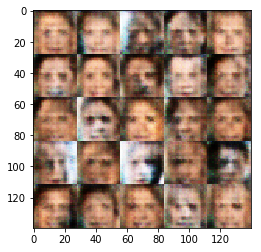

Epoch 1/1... Discriminator loss: 1.4828 Generator loss: 0.8593
Epoch 1/1... Discriminator loss: 1.3140 Generator loss: 0.9857
Epoch 1/1... Discriminator loss: 1.4863 Generator loss: 0.8108
Epoch 1/1... Discriminator loss: 1.4210 Generator loss: 0.9387
Epoch 1/1... Discriminator loss: 1.5716 Generator loss: 0.9082
Epoch 1/1... Discriminator loss: 1.4437 Generator loss: 0.7930
Epoch 1/1... Discriminator loss: 1.3266 Generator loss: 0.9884
Epoch 1/1... Discriminator loss: 1.2468 Generator loss: 1.1984
Epoch 1/1... Discriminator loss: 1.4819 Generator loss: 0.7857
Epoch 1/1... Discriminator loss: 1.3025 Generator loss: 1.0504


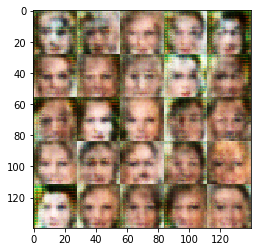

Epoch 1/1... Discriminator loss: 1.4464 Generator loss: 0.9564
Epoch 1/1... Discriminator loss: 1.4518 Generator loss: 0.8049
Epoch 1/1... Discriminator loss: 1.5491 Generator loss: 0.8398
Epoch 1/1... Discriminator loss: 1.4826 Generator loss: 0.9500
Epoch 1/1... Discriminator loss: 1.4060 Generator loss: 0.7638
Epoch 1/1... Discriminator loss: 1.3612 Generator loss: 0.8439
Epoch 1/1... Discriminator loss: 1.3629 Generator loss: 0.7742
Epoch 1/1... Discriminator loss: 1.3653 Generator loss: 0.8323
Epoch 1/1... Discriminator loss: 1.4527 Generator loss: 0.7882
Epoch 1/1... Discriminator loss: 1.4019 Generator loss: 0.7674


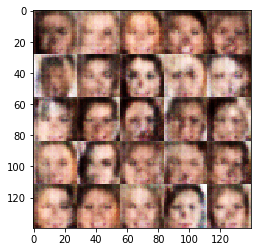

Epoch 1/1... Discriminator loss: 1.5850 Generator loss: 0.7390
Epoch 1/1... Discriminator loss: 1.4011 Generator loss: 0.9231
Epoch 1/1... Discriminator loss: 1.2679 Generator loss: 1.2982
Epoch 1/1... Discriminator loss: 1.5554 Generator loss: 0.9098
Epoch 1/1... Discriminator loss: 1.5343 Generator loss: 0.8137
Epoch 1/1... Discriminator loss: 1.4790 Generator loss: 0.8830
Epoch 1/1... Discriminator loss: 1.6240 Generator loss: 0.8039
Epoch 1/1... Discriminator loss: 1.5486 Generator loss: 0.7901
Epoch 1/1... Discriminator loss: 1.4253 Generator loss: 0.6904
Epoch 1/1... Discriminator loss: 1.4372 Generator loss: 0.8336


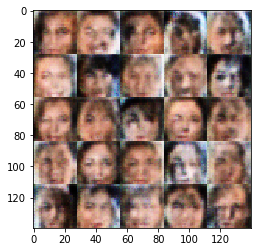

Epoch 1/1... Discriminator loss: 1.3999 Generator loss: 0.7633
Epoch 1/1... Discriminator loss: 1.3870 Generator loss: 0.8524
Epoch 1/1... Discriminator loss: 1.4707 Generator loss: 0.8328
Epoch 1/1... Discriminator loss: 1.7011 Generator loss: 0.6909
Epoch 1/1... Discriminator loss: 1.5508 Generator loss: 0.7961
Epoch 1/1... Discriminator loss: 1.3855 Generator loss: 0.7912
Epoch 1/1... Discriminator loss: 1.4413 Generator loss: 0.7443
Epoch 1/1... Discriminator loss: 1.4007 Generator loss: 0.9297
Epoch 1/1... Discriminator loss: 1.4612 Generator loss: 0.8785
Epoch 1/1... Discriminator loss: 1.5362 Generator loss: 0.8476


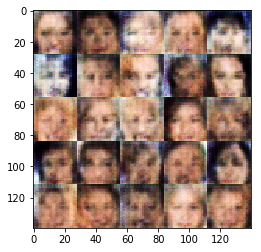

Epoch 1/1... Discriminator loss: 1.4372 Generator loss: 0.8311
Epoch 1/1... Discriminator loss: 1.3949 Generator loss: 0.8579
Epoch 1/1... Discriminator loss: 1.5957 Generator loss: 0.7736
Epoch 1/1... Discriminator loss: 1.4732 Generator loss: 0.8008
Epoch 1/1... Discriminator loss: 1.4001 Generator loss: 0.9266
Epoch 1/1... Discriminator loss: 1.2446 Generator loss: 0.7480
Epoch 1/1... Discriminator loss: 1.4080 Generator loss: 0.8110
Epoch 1/1... Discriminator loss: 1.4251 Generator loss: 0.8147
Epoch 1/1... Discriminator loss: 1.4510 Generator loss: 0.8048
Epoch 1/1... Discriminator loss: 1.4009 Generator loss: 0.8217


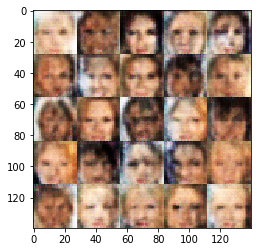

Epoch 1/1... Discriminator loss: 1.4919 Generator loss: 0.7973
Epoch 1/1... Discriminator loss: 1.4213 Generator loss: 0.8124
Epoch 1/1... Discriminator loss: 1.4652 Generator loss: 0.8037
Epoch 1/1... Discriminator loss: 1.4405 Generator loss: 0.8854
Epoch 1/1... Discriminator loss: 1.4442 Generator loss: 0.9428
Epoch 1/1... Discriminator loss: 1.3519 Generator loss: 0.7498
Epoch 1/1... Discriminator loss: 1.5616 Generator loss: 0.8106
Epoch 1/1... Discriminator loss: 1.4071 Generator loss: 0.7311
Epoch 1/1... Discriminator loss: 1.5430 Generator loss: 0.7776
Epoch 1/1... Discriminator loss: 1.3865 Generator loss: 0.8539


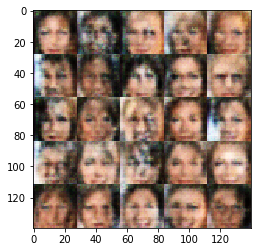

Epoch 1/1... Discriminator loss: 1.3393 Generator loss: 0.8998
Epoch 1/1... Discriminator loss: 1.4707 Generator loss: 0.7511
Epoch 1/1... Discriminator loss: 1.3659 Generator loss: 0.8153
Epoch 1/1... Discriminator loss: 1.4578 Generator loss: 0.8450
Epoch 1/1... Discriminator loss: 1.5624 Generator loss: 0.8649
Epoch 1/1... Discriminator loss: 1.5492 Generator loss: 0.8127
Epoch 1/1... Discriminator loss: 1.5341 Generator loss: 0.7514
Epoch 1/1... Discriminator loss: 1.4029 Generator loss: 0.8106
Epoch 1/1... Discriminator loss: 1.5063 Generator loss: 0.8071
Epoch 1/1... Discriminator loss: 1.4779 Generator loss: 0.8084


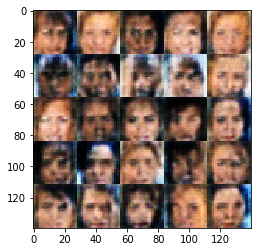

Epoch 1/1... Discriminator loss: 1.5143 Generator loss: 0.8140
Epoch 1/1... Discriminator loss: 1.4044 Generator loss: 0.8592
Epoch 1/1... Discriminator loss: 1.5160 Generator loss: 0.8277
Epoch 1/1... Discriminator loss: 1.4416 Generator loss: 0.8509
Epoch 1/1... Discriminator loss: 1.5079 Generator loss: 0.8373
Epoch 1/1... Discriminator loss: 1.3713 Generator loss: 0.8537
Epoch 1/1... Discriminator loss: 1.4586 Generator loss: 0.7762
Epoch 1/1... Discriminator loss: 1.4285 Generator loss: 0.8569
Epoch 1/1... Discriminator loss: 1.3415 Generator loss: 0.7938
Epoch 1/1... Discriminator loss: 1.4646 Generator loss: 0.8837


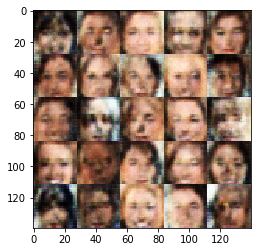

Epoch 1/1... Discriminator loss: 1.4710 Generator loss: 0.6906
Epoch 1/1... Discriminator loss: 1.4342 Generator loss: 0.9149
Epoch 1/1... Discriminator loss: 1.3819 Generator loss: 0.8691
Epoch 1/1... Discriminator loss: 1.4384 Generator loss: 0.7365
Epoch 1/1... Discriminator loss: 1.4791 Generator loss: 0.8443
Epoch 1/1... Discriminator loss: 1.4406 Generator loss: 0.7533
Epoch 1/1... Discriminator loss: 1.3976 Generator loss: 0.7753
Epoch 1/1... Discriminator loss: 1.4393 Generator loss: 0.6768
Epoch 1/1... Discriminator loss: 1.4303 Generator loss: 0.8860
Epoch 1/1... Discriminator loss: 1.3718 Generator loss: 0.9589


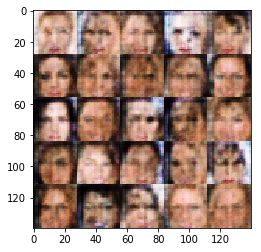

Epoch 1/1... Discriminator loss: 1.4426 Generator loss: 0.9240
Epoch 1/1... Discriminator loss: 1.4572 Generator loss: 0.8689
Epoch 1/1... Discriminator loss: 1.4117 Generator loss: 0.7474
Epoch 1/1... Discriminator loss: 1.3652 Generator loss: 0.8085
Epoch 1/1... Discriminator loss: 1.5103 Generator loss: 0.8238
Epoch 1/1... Discriminator loss: 1.4698 Generator loss: 0.7462
Epoch 1/1... Discriminator loss: 1.4667 Generator loss: 0.8109
Epoch 1/1... Discriminator loss: 1.5339 Generator loss: 0.8494
Epoch 1/1... Discriminator loss: 1.4220 Generator loss: 0.8429
Epoch 1/1... Discriminator loss: 1.3571 Generator loss: 0.8220


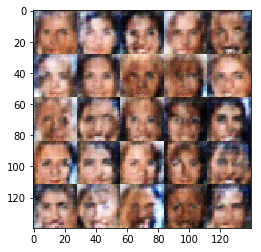

Epoch 1/1... Discriminator loss: 1.3470 Generator loss: 0.8354
Epoch 1/1... Discriminator loss: 1.3866 Generator loss: 0.8292
Epoch 1/1... Discriminator loss: 1.3014 Generator loss: 0.9535
Epoch 1/1... Discriminator loss: 1.3193 Generator loss: 0.7475
Epoch 1/1... Discriminator loss: 1.4034 Generator loss: 0.8924
Epoch 1/1... Discriminator loss: 1.4345 Generator loss: 0.8329
Epoch 1/1... Discriminator loss: 1.3606 Generator loss: 0.8243
Epoch 1/1... Discriminator loss: 1.4843 Generator loss: 0.7550
Epoch 1/1... Discriminator loss: 1.4315 Generator loss: 0.8206
Epoch 1/1... Discriminator loss: 1.3942 Generator loss: 0.8305


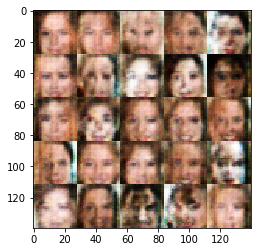

Epoch 1/1... Discriminator loss: 1.2869 Generator loss: 0.7781
Epoch 1/1... Discriminator loss: 1.5083 Generator loss: 0.7549
Epoch 1/1... Discriminator loss: 1.4226 Generator loss: 0.7937
Epoch 1/1... Discriminator loss: 1.3570 Generator loss: 0.8761
Epoch 1/1... Discriminator loss: 1.4462 Generator loss: 0.7636
Epoch 1/1... Discriminator loss: 1.3344 Generator loss: 0.8192
Epoch 1/1... Discriminator loss: 1.4346 Generator loss: 0.7738
Epoch 1/1... Discriminator loss: 1.4524 Generator loss: 0.8284
Epoch 1/1... Discriminator loss: 1.4363 Generator loss: 0.7230
Epoch 1/1... Discriminator loss: 1.4440 Generator loss: 0.7750


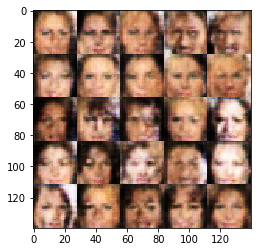

Epoch 1/1... Discriminator loss: 1.3850 Generator loss: 0.7707
Epoch 1/1... Discriminator loss: 1.3483 Generator loss: 1.0268
Epoch 1/1... Discriminator loss: 1.4249 Generator loss: 0.7717
Epoch 1/1... Discriminator loss: 1.4101 Generator loss: 0.8163
Epoch 1/1... Discriminator loss: 1.4552 Generator loss: 0.8292
Epoch 1/1... Discriminator loss: 1.3835 Generator loss: 0.9461
Epoch 1/1... Discriminator loss: 1.4351 Generator loss: 0.8125
Epoch 1/1... Discriminator loss: 1.3374 Generator loss: 0.8243
Epoch 1/1... Discriminator loss: 1.4468 Generator loss: 0.8680
Epoch 1/1... Discriminator loss: 1.4640 Generator loss: 0.8788


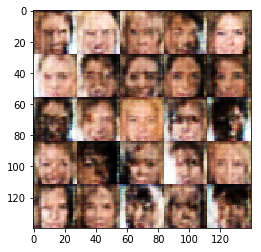

Epoch 1/1... Discriminator loss: 1.4182 Generator loss: 0.8900
Epoch 1/1... Discriminator loss: 1.4788 Generator loss: 0.8119
Epoch 1/1... Discriminator loss: 1.4656 Generator loss: 0.8527
Epoch 1/1... Discriminator loss: 1.4897 Generator loss: 0.7547
Epoch 1/1... Discriminator loss: 1.4183 Generator loss: 0.8087
Epoch 1/1... Discriminator loss: 1.5122 Generator loss: 0.7195
Epoch 1/1... Discriminator loss: 1.3975 Generator loss: 0.8447
Epoch 1/1... Discriminator loss: 1.3865 Generator loss: 0.7559
Epoch 1/1... Discriminator loss: 1.3894 Generator loss: 0.7863
Epoch 1/1... Discriminator loss: 1.3615 Generator loss: 0.8061


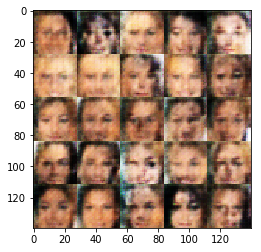

Epoch 1/1... Discriminator loss: 1.3885 Generator loss: 0.8372
Epoch 1/1... Discriminator loss: 1.4252 Generator loss: 0.7708
Epoch 1/1... Discriminator loss: 1.3411 Generator loss: 0.8426
Epoch 1/1... Discriminator loss: 1.3564 Generator loss: 0.8123
Epoch 1/1... Discriminator loss: 1.4231 Generator loss: 0.8003
Epoch 1/1... Discriminator loss: 1.3502 Generator loss: 0.8434
Epoch 1/1... Discriminator loss: 1.4074 Generator loss: 0.8830
Epoch 1/1... Discriminator loss: 1.4473 Generator loss: 0.7691
Epoch 1/1... Discriminator loss: 1.4673 Generator loss: 0.7074
Epoch 1/1... Discriminator loss: 1.4949 Generator loss: 0.9551


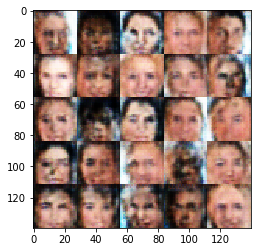

Epoch 1/1... Discriminator loss: 1.4821 Generator loss: 0.8667
Epoch 1/1... Discriminator loss: 1.4181 Generator loss: 0.7817
Epoch 1/1... Discriminator loss: 1.3162 Generator loss: 0.8431
Epoch 1/1... Discriminator loss: 1.4734 Generator loss: 0.7993
Epoch 1/1... Discriminator loss: 1.4077 Generator loss: 0.8772
Epoch 1/1... Discriminator loss: 1.4468 Generator loss: 0.8068
Epoch 1/1... Discriminator loss: 1.3385 Generator loss: 0.9722
Epoch 1/1... Discriminator loss: 1.3417 Generator loss: 0.8544
Epoch 1/1... Discriminator loss: 1.4221 Generator loss: 0.8475
Epoch 1/1... Discriminator loss: 1.3328 Generator loss: 0.8278


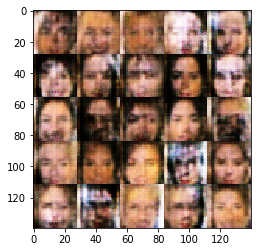

Epoch 1/1... Discriminator loss: 1.3714 Generator loss: 0.8522
Epoch 1/1... Discriminator loss: 1.5242 Generator loss: 0.9049
Epoch 1/1... Discriminator loss: 1.4331 Generator loss: 0.8916
Epoch 1/1... Discriminator loss: 1.3600 Generator loss: 0.8476
Epoch 1/1... Discriminator loss: 1.3744 Generator loss: 0.8397
Epoch 1/1... Discriminator loss: 1.3033 Generator loss: 0.8473
Epoch 1/1... Discriminator loss: 1.4162 Generator loss: 0.8504
Epoch 1/1... Discriminator loss: 1.4471 Generator loss: 0.8071
Epoch 1/1... Discriminator loss: 1.5079 Generator loss: 0.8196
Epoch 1/1... Discriminator loss: 1.3931 Generator loss: 0.8949


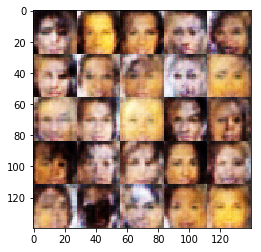

Epoch 1/1... Discriminator loss: 1.4114 Generator loss: 0.7647
Epoch 1/1... Discriminator loss: 1.5494 Generator loss: 0.8938
Epoch 1/1... Discriminator loss: 1.5829 Generator loss: 0.8996
Epoch 1/1... Discriminator loss: 1.3144 Generator loss: 0.8646
Epoch 1/1... Discriminator loss: 1.3738 Generator loss: 0.7838
Epoch 1/1... Discriminator loss: 1.3319 Generator loss: 0.8674
Epoch 1/1... Discriminator loss: 1.4218 Generator loss: 0.6869
Epoch 1/1... Discriminator loss: 1.4924 Generator loss: 0.7853
Epoch 1/1... Discriminator loss: 1.4756 Generator loss: 0.7798
Epoch 1/1... Discriminator loss: 1.3290 Generator loss: 0.6791


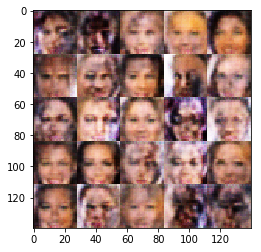

Epoch 1/1... Discriminator loss: 1.4400 Generator loss: 0.8512
Epoch 1/1... Discriminator loss: 1.3848 Generator loss: 0.8521
Epoch 1/1... Discriminator loss: 1.4110 Generator loss: 1.0682
Epoch 1/1... Discriminator loss: 1.3775 Generator loss: 0.8887
Epoch 1/1... Discriminator loss: 1.4137 Generator loss: 0.8127
Epoch 1/1... Discriminator loss: 1.3915 Generator loss: 0.8365
Epoch 1/1... Discriminator loss: 1.3237 Generator loss: 0.7172
Epoch 1/1... Discriminator loss: 1.4090 Generator loss: 0.8213
Epoch 1/1... Discriminator loss: 1.4241 Generator loss: 0.7538
Epoch 1/1... Discriminator loss: 1.5062 Generator loss: 0.6259


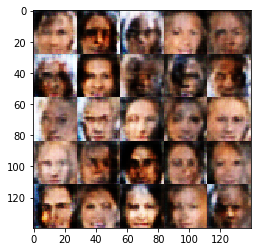

Epoch 1/1... Discriminator loss: 1.3569 Generator loss: 0.7130
Epoch 1/1... Discriminator loss: 1.3094 Generator loss: 0.7886
Epoch 1/1... Discriminator loss: 1.4503 Generator loss: 0.7532
Epoch 1/1... Discriminator loss: 1.4064 Generator loss: 0.8485
Epoch 1/1... Discriminator loss: 1.4245 Generator loss: 0.7931
Epoch 1/1... Discriminator loss: 1.4055 Generator loss: 0.8622
Epoch 1/1... Discriminator loss: 1.4331 Generator loss: 0.7761
Epoch 1/1... Discriminator loss: 1.3559 Generator loss: 0.8633
Epoch 1/1... Discriminator loss: 1.3949 Generator loss: 0.8448
Epoch 1/1... Discriminator loss: 1.4303 Generator loss: 0.8043


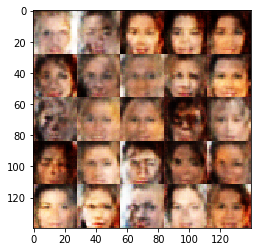

Epoch 1/1... Discriminator loss: 1.3337 Generator loss: 0.9247
Epoch 1/1... Discriminator loss: 1.3910 Generator loss: 0.8539
Epoch 1/1... Discriminator loss: 1.3062 Generator loss: 0.8179
Epoch 1/1... Discriminator loss: 1.4014 Generator loss: 1.0026
Epoch 1/1... Discriminator loss: 1.2681 Generator loss: 1.0310
Epoch 1/1... Discriminator loss: 1.5313 Generator loss: 0.9116
Epoch 1/1... Discriminator loss: 1.4252 Generator loss: 0.8303
Epoch 1/1... Discriminator loss: 1.4464 Generator loss: 0.8379
Epoch 1/1... Discriminator loss: 1.4413 Generator loss: 0.7922
Epoch 1/1... Discriminator loss: 1.4017 Generator loss: 0.8689


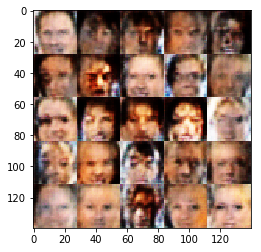

Epoch 1/1... Discriminator loss: 1.4527 Generator loss: 0.7902
Epoch 1/1... Discriminator loss: 1.3746 Generator loss: 1.0075
Epoch 1/1... Discriminator loss: 1.3617 Generator loss: 0.8472
Epoch 1/1... Discriminator loss: 1.4185 Generator loss: 0.8988
Epoch 1/1... Discriminator loss: 1.4222 Generator loss: 0.9124
Epoch 1/1... Discriminator loss: 1.3903 Generator loss: 0.8912
Epoch 1/1... Discriminator loss: 1.2925 Generator loss: 0.7744
Epoch 1/1... Discriminator loss: 1.3044 Generator loss: 0.8927
Epoch 1/1... Discriminator loss: 1.3929 Generator loss: 0.7348
Epoch 1/1... Discriminator loss: 1.2963 Generator loss: 0.9231


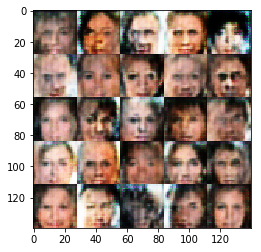

Epoch 1/1... Discriminator loss: 1.4377 Generator loss: 0.7057
Epoch 1/1... Discriminator loss: 1.3816 Generator loss: 0.8184
Epoch 1/1... Discriminator loss: 1.3632 Generator loss: 0.9369
Epoch 1/1... Discriminator loss: 1.4137 Generator loss: 0.8360
Epoch 1/1... Discriminator loss: 1.4604 Generator loss: 0.8311
Epoch 1/1... Discriminator loss: 1.4788 Generator loss: 0.8630
Epoch 1/1... Discriminator loss: 1.4904 Generator loss: 0.6950
Epoch 1/1... Discriminator loss: 1.2779 Generator loss: 0.7799
Epoch 1/1... Discriminator loss: 1.4156 Generator loss: 0.9283
Epoch 1/1... Discriminator loss: 1.2858 Generator loss: 0.8659


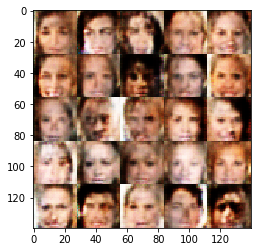

Epoch 1/1... Discriminator loss: 1.2576 Generator loss: 0.9824
Epoch 1/1... Discriminator loss: 1.4007 Generator loss: 0.8558
Epoch 1/1... Discriminator loss: 1.4656 Generator loss: 0.7668
Epoch 1/1... Discriminator loss: 1.3735 Generator loss: 0.8107
Epoch 1/1... Discriminator loss: 1.3692 Generator loss: 0.8488
Epoch 1/1... Discriminator loss: 1.3520 Generator loss: 0.8699
Epoch 1/1... Discriminator loss: 1.3883 Generator loss: 0.7252
Epoch 1/1... Discriminator loss: 1.2900 Generator loss: 0.9293
Epoch 1/1... Discriminator loss: 1.5044 Generator loss: 0.6861
Epoch 1/1... Discriminator loss: 1.3425 Generator loss: 0.7821


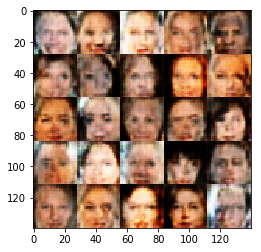

Epoch 1/1... Discriminator loss: 1.2544 Generator loss: 1.2975
Epoch 1/1... Discriminator loss: 1.2732 Generator loss: 0.8452
Epoch 1/1... Discriminator loss: 1.4230 Generator loss: 0.8968
Epoch 1/1... Discriminator loss: 1.1846 Generator loss: 1.3704
Epoch 1/1... Discriminator loss: 1.2799 Generator loss: 0.9472
Epoch 1/1... Discriminator loss: 1.2411 Generator loss: 0.7712
Epoch 1/1... Discriminator loss: 1.4408 Generator loss: 0.7922
Epoch 1/1... Discriminator loss: 1.2654 Generator loss: 0.9224
Epoch 1/1... Discriminator loss: 1.3626 Generator loss: 0.6807
Epoch 1/1... Discriminator loss: 1.4329 Generator loss: 0.7110


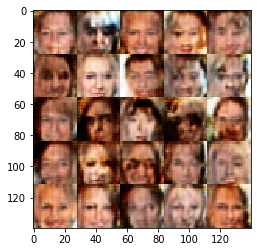

Epoch 1/1... Discriminator loss: 1.2944 Generator loss: 0.9203
Epoch 1/1... Discriminator loss: 1.3898 Generator loss: 1.0708
Epoch 1/1... Discriminator loss: 1.4049 Generator loss: 0.5841
Epoch 1/1... Discriminator loss: 1.3005 Generator loss: 0.6248
Epoch 1/1... Discriminator loss: 1.4059 Generator loss: 0.7253
Epoch 1/1... Discriminator loss: 1.2898 Generator loss: 0.8524
Epoch 1/1... Discriminator loss: 1.2238 Generator loss: 0.9361
Epoch 1/1... Discriminator loss: 1.3786 Generator loss: 0.8160
Epoch 1/1... Discriminator loss: 1.3685 Generator loss: 0.8818
Epoch 1/1... Discriminator loss: 1.3624 Generator loss: 0.6909


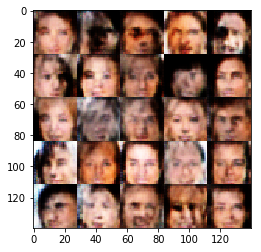

Epoch 1/1... Discriminator loss: 1.4132 Generator loss: 0.8536
Epoch 1/1... Discriminator loss: 1.3567 Generator loss: 0.8586
Epoch 1/1... Discriminator loss: 1.3458 Generator loss: 0.9511
Epoch 1/1... Discriminator loss: 1.3651 Generator loss: 1.0152
Epoch 1/1... Discriminator loss: 1.2134 Generator loss: 0.9895
Epoch 1/1... Discriminator loss: 1.2434 Generator loss: 1.0301
Epoch 1/1... Discriminator loss: 1.3424 Generator loss: 0.7835
Epoch 1/1... Discriminator loss: 1.3759 Generator loss: 0.9339
Epoch 1/1... Discriminator loss: 1.4484 Generator loss: 0.8699
Epoch 1/1... Discriminator loss: 1.3046 Generator loss: 0.7793


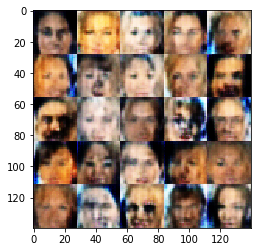

Epoch 1/1... Discriminator loss: 1.3337 Generator loss: 0.7819
Epoch 1/1... Discriminator loss: 1.3325 Generator loss: 0.8381
Epoch 1/1... Discriminator loss: 1.3047 Generator loss: 0.9203
Epoch 1/1... Discriminator loss: 1.4689 Generator loss: 0.8637
Epoch 1/1... Discriminator loss: 1.4961 Generator loss: 0.8266
Epoch 1/1... Discriminator loss: 1.3595 Generator loss: 0.8883
Epoch 1/1... Discriminator loss: 1.5265 Generator loss: 0.7342
Epoch 1/1... Discriminator loss: 1.3504 Generator loss: 0.7496
Epoch 1/1... Discriminator loss: 1.2751 Generator loss: 0.9327
Epoch 1/1... Discriminator loss: 1.3995 Generator loss: 0.8401


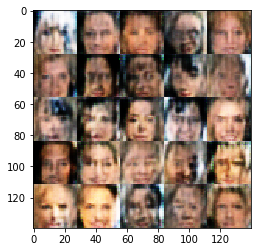

Epoch 1/1... Discriminator loss: 1.4858 Generator loss: 0.9449
Epoch 1/1... Discriminator loss: 1.3858 Generator loss: 0.8038
Epoch 1/1... Discriminator loss: 1.4432 Generator loss: 0.8777
Epoch 1/1... Discriminator loss: 1.4572 Generator loss: 1.0125
Epoch 1/1... Discriminator loss: 1.2760 Generator loss: 0.8718
Epoch 1/1... Discriminator loss: 1.4717 Generator loss: 0.8252
Epoch 1/1... Discriminator loss: 1.3880 Generator loss: 0.8544
Epoch 1/1... Discriminator loss: 1.4132 Generator loss: 0.7736
Epoch 1/1... Discriminator loss: 1.4060 Generator loss: 0.7948
Epoch 1/1... Discriminator loss: 1.3164 Generator loss: 0.9117


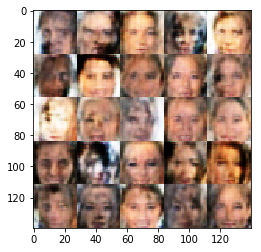

Epoch 1/1... Discriminator loss: 1.4782 Generator loss: 0.7953
Epoch 1/1... Discriminator loss: 1.5721 Generator loss: 0.7406
Epoch 1/1... Discriminator loss: 1.3955 Generator loss: 0.8193
Epoch 1/1... Discriminator loss: 1.4352 Generator loss: 0.7140
Epoch 1/1... Discriminator loss: 1.4037 Generator loss: 0.8173
Epoch 1/1... Discriminator loss: 1.3525 Generator loss: 0.8908
Epoch 1/1... Discriminator loss: 1.4075 Generator loss: 0.8441
Epoch 1/1... Discriminator loss: 1.4045 Generator loss: 0.8362
Epoch 1/1... Discriminator loss: 1.4055 Generator loss: 0.8400
Epoch 1/1... Discriminator loss: 1.3721 Generator loss: 0.8990


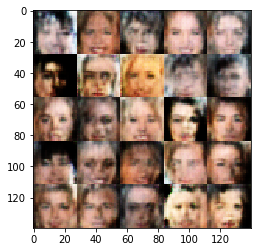

Epoch 1/1... Discriminator loss: 1.4429 Generator loss: 0.7628
Epoch 1/1... Discriminator loss: 1.4208 Generator loss: 0.9404
Epoch 1/1... Discriminator loss: 1.3353 Generator loss: 0.7665
Epoch 1/1... Discriminator loss: 1.4260 Generator loss: 0.8340
Epoch 1/1... Discriminator loss: 1.3690 Generator loss: 0.8054
Epoch 1/1... Discriminator loss: 1.5038 Generator loss: 0.7515
Epoch 1/1... Discriminator loss: 1.4186 Generator loss: 0.7308
Epoch 1/1... Discriminator loss: 1.4035 Generator loss: 0.7740
Epoch 1/1... Discriminator loss: 1.3991 Generator loss: 0.8256
Epoch 1/1... Discriminator loss: 1.4612 Generator loss: 0.7701


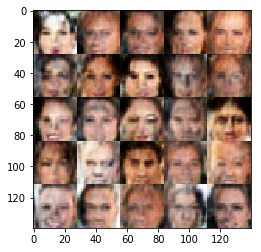

Epoch 1/1... Discriminator loss: 1.3447 Generator loss: 0.8516
Epoch 1/1... Discriminator loss: 1.4768 Generator loss: 0.7773
Epoch 1/1... Discriminator loss: 1.4124 Generator loss: 0.9254
Epoch 1/1... Discriminator loss: 1.3772 Generator loss: 0.8632
Epoch 1/1... Discriminator loss: 1.4457 Generator loss: 0.7842
Epoch 1/1... Discriminator loss: 1.4160 Generator loss: 0.7991
Epoch 1/1... Discriminator loss: 1.3928 Generator loss: 0.8070
Epoch 1/1... Discriminator loss: 1.4395 Generator loss: 0.8006
Epoch 1/1... Discriminator loss: 1.4016 Generator loss: 0.8277
Epoch 1/1... Discriminator loss: 1.3942 Generator loss: 0.8869


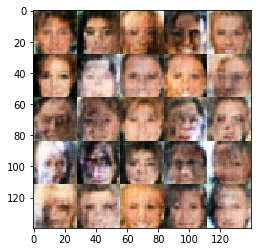

Epoch 1/1... Discriminator loss: 1.4341 Generator loss: 0.8559
Epoch 1/1... Discriminator loss: 1.3848 Generator loss: 0.8728
Epoch 1/1... Discriminator loss: 1.4410 Generator loss: 0.8073
Epoch 1/1... Discriminator loss: 1.3257 Generator loss: 0.8613
Epoch 1/1... Discriminator loss: 1.4804 Generator loss: 0.8411
Epoch 1/1... Discriminator loss: 1.3890 Generator loss: 0.8438
Epoch 1/1... Discriminator loss: 1.4006 Generator loss: 0.7231
Epoch 1/1... Discriminator loss: 1.3392 Generator loss: 0.7042
Epoch 1/1... Discriminator loss: 1.3736 Generator loss: 0.8198
Epoch 1/1... Discriminator loss: 1.5049 Generator loss: 0.8513


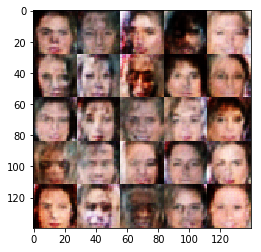

Epoch 1/1... Discriminator loss: 1.4064 Generator loss: 0.8723
Epoch 1/1... Discriminator loss: 1.3985 Generator loss: 0.8598
Epoch 1/1... Discriminator loss: 1.4060 Generator loss: 0.7697
Epoch 1/1... Discriminator loss: 1.4499 Generator loss: 0.8644
Epoch 1/1... Discriminator loss: 1.3956 Generator loss: 0.8909
Epoch 1/1... Discriminator loss: 1.4465 Generator loss: 0.7260
Epoch 1/1... Discriminator loss: 1.3206 Generator loss: 0.7550
Epoch 1/1... Discriminator loss: 1.4280 Generator loss: 0.8330
Epoch 1/1... Discriminator loss: 1.4108 Generator loss: 0.8262
Epoch 1/1... Discriminator loss: 1.3858 Generator loss: 0.8249


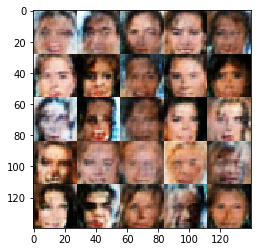

Epoch 1/1... Discriminator loss: 1.4156 Generator loss: 0.8059
Epoch 1/1... Discriminator loss: 1.3400 Generator loss: 0.8524
Epoch 1/1... Discriminator loss: 1.4250 Generator loss: 0.7732
Epoch 1/1... Discriminator loss: 1.3661 Generator loss: 0.8057
Epoch 1/1... Discriminator loss: 1.4094 Generator loss: 0.8685
Epoch 1/1... Discriminator loss: 1.4349 Generator loss: 0.7708
Epoch 1/1... Discriminator loss: 1.3978 Generator loss: 0.8396
Epoch 1/1... Discriminator loss: 1.3490 Generator loss: 0.7922
Epoch 1/1... Discriminator loss: 1.4038 Generator loss: 0.7867
Epoch 1/1... Discriminator loss: 1.4104 Generator loss: 0.8863


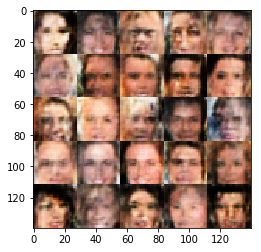

Epoch 1/1... Discriminator loss: 1.3507 Generator loss: 0.8466
Epoch 1/1... Discriminator loss: 1.4003 Generator loss: 0.8515
Epoch 1/1... Discriminator loss: 1.3814 Generator loss: 0.7831
Epoch 1/1... Discriminator loss: 1.3577 Generator loss: 0.7254
Epoch 1/1... Discriminator loss: 1.3347 Generator loss: 0.7444
Epoch 1/1... Discriminator loss: 1.3588 Generator loss: 0.7570
Epoch 1/1... Discriminator loss: 1.3108 Generator loss: 0.8292
Epoch 1/1... Discriminator loss: 1.3213 Generator loss: 0.9052
Epoch 1/1... Discriminator loss: 1.3754 Generator loss: 0.7873
Epoch 1/1... Discriminator loss: 1.3693 Generator loss: 0.8607


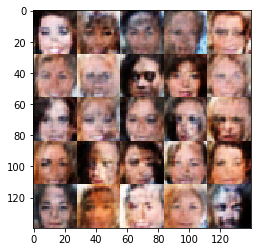

Epoch 1/1... Discriminator loss: 1.3579 Generator loss: 0.8589
Epoch 1/1... Discriminator loss: 1.3987 Generator loss: 0.8377
Epoch 1/1... Discriminator loss: 1.4751 Generator loss: 0.8380
Epoch 1/1... Discriminator loss: 1.3742 Generator loss: 0.8312
Epoch 1/1... Discriminator loss: 1.3583 Generator loss: 0.8521
Epoch 1/1... Discriminator loss: 1.4724 Generator loss: 0.7962
Epoch 1/1... Discriminator loss: 1.4343 Generator loss: 0.7335
Epoch 1/1... Discriminator loss: 1.4002 Generator loss: 0.8416
Epoch 1/1... Discriminator loss: 1.3736 Generator loss: 0.8039
Epoch 1/1... Discriminator loss: 1.3371 Generator loss: 0.8194


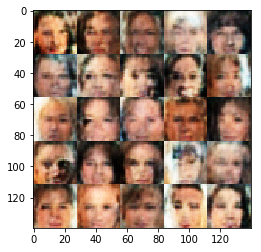

Epoch 1/1... Discriminator loss: 1.4264 Generator loss: 0.7853
Epoch 1/1... Discriminator loss: 1.3259 Generator loss: 0.7776
Epoch 1/1... Discriminator loss: 1.4472 Generator loss: 0.8121
Epoch 1/1... Discriminator loss: 1.3875 Generator loss: 0.7371
Epoch 1/1... Discriminator loss: 1.4232 Generator loss: 0.7717
Epoch 1/1... Discriminator loss: 1.3835 Generator loss: 0.8060
Epoch 1/1... Discriminator loss: 1.3817 Generator loss: 0.8619
Epoch 1/1... Discriminator loss: 1.3708 Generator loss: 0.7514
Epoch 1/1... Discriminator loss: 1.3782 Generator loss: 0.8458
Epoch 1/1... Discriminator loss: 1.4828 Generator loss: 0.9147


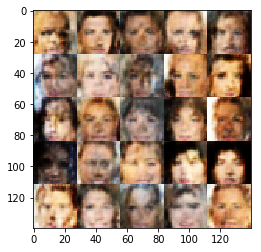

Epoch 1/1... Discriminator loss: 1.3884 Generator loss: 0.8043
Epoch 1/1... Discriminator loss: 1.3395 Generator loss: 0.7820
Epoch 1/1... Discriminator loss: 1.3912 Generator loss: 0.8134
Epoch 1/1... Discriminator loss: 1.3547 Generator loss: 0.7942
Epoch 1/1... Discriminator loss: 1.3612 Generator loss: 0.9309
Epoch 1/1... Discriminator loss: 1.3625 Generator loss: 0.7462
Epoch 1/1... Discriminator loss: 1.4210 Generator loss: 0.8481
Epoch 1/1... Discriminator loss: 1.3920 Generator loss: 0.8551
Epoch 1/1... Discriminator loss: 1.3957 Generator loss: 0.8869
Epoch 1/1... Discriminator loss: 1.3985 Generator loss: 0.8156


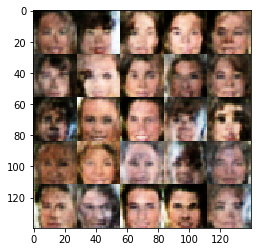

Epoch 1/1... Discriminator loss: 1.3961 Generator loss: 0.8262
Epoch 1/1... Discriminator loss: 1.3531 Generator loss: 0.8026
Epoch 1/1... Discriminator loss: 1.3352 Generator loss: 1.0078
Epoch 1/1... Discriminator loss: 1.4052 Generator loss: 0.7662
Epoch 1/1... Discriminator loss: 1.3540 Generator loss: 0.8775
Epoch 1/1... Discriminator loss: 1.4306 Generator loss: 0.8513
Epoch 1/1... Discriminator loss: 1.4736 Generator loss: 0.7146
Epoch 1/1... Discriminator loss: 1.3980 Generator loss: 0.8109
Epoch 1/1... Discriminator loss: 1.3721 Generator loss: 0.8354
Epoch 1/1... Discriminator loss: 1.3888 Generator loss: 0.7620


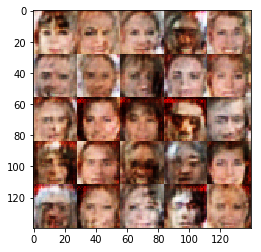

Epoch 1/1... Discriminator loss: 1.3930 Generator loss: 0.7499
Epoch 1/1... Discriminator loss: 1.4223 Generator loss: 0.8950
Epoch 1/1... Discriminator loss: 1.4300 Generator loss: 0.7427
Epoch 1/1... Discriminator loss: 1.3663 Generator loss: 0.7575
Epoch 1/1... Discriminator loss: 1.3840 Generator loss: 0.8015
Epoch 1/1... Discriminator loss: 1.4146 Generator loss: 0.7930
Epoch 1/1... Discriminator loss: 1.3910 Generator loss: 0.7464
Epoch 1/1... Discriminator loss: 1.3954 Generator loss: 0.9187
Epoch 1/1... Discriminator loss: 1.3406 Generator loss: 0.8312
Epoch 1/1... Discriminator loss: 1.4438 Generator loss: 0.7689


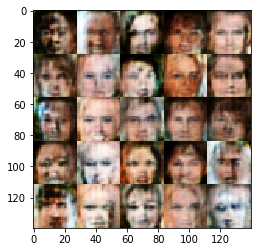

Epoch 1/1... Discriminator loss: 1.4192 Generator loss: 0.7746
Epoch 1/1... Discriminator loss: 1.3691 Generator loss: 0.7942
Epoch 1/1... Discriminator loss: 1.4326 Generator loss: 0.8536
Epoch 1/1... Discriminator loss: 1.3895 Generator loss: 0.8073
Epoch 1/1... Discriminator loss: 1.4305 Generator loss: 0.7880
Epoch 1/1... Discriminator loss: 1.3188 Generator loss: 0.8550
Epoch 1/1... Discriminator loss: 1.3520 Generator loss: 0.7388
Epoch 1/1... Discriminator loss: 1.3923 Generator loss: 0.9167
Epoch 1/1... Discriminator loss: 1.3084 Generator loss: 0.7926
Epoch 1/1... Discriminator loss: 1.4356 Generator loss: 0.8394


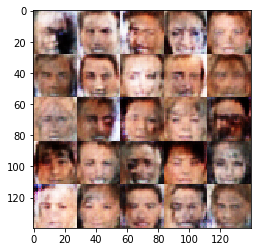

Epoch 1/1... Discriminator loss: 1.4105 Generator loss: 0.7375
Epoch 1/1... Discriminator loss: 1.3807 Generator loss: 0.7996
Epoch 1/1... Discriminator loss: 1.3578 Generator loss: 0.8257
Epoch 1/1... Discriminator loss: 1.3879 Generator loss: 0.8170
Epoch 1/1... Discriminator loss: 1.3847 Generator loss: 0.8625
Epoch 1/1... Discriminator loss: 1.3734 Generator loss: 0.7817
Epoch 1/1... Discriminator loss: 1.3752 Generator loss: 0.7943
Epoch 1/1... Discriminator loss: 1.3611 Generator loss: 0.9488
Epoch 1/1... Discriminator loss: 1.4335 Generator loss: 0.7763
Epoch 1/1... Discriminator loss: 1.3786 Generator loss: 0.8095


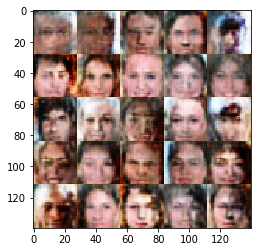

Epoch 1/1... Discriminator loss: 1.4052 Generator loss: 0.7112
Epoch 1/1... Discriminator loss: 1.3655 Generator loss: 0.8586
Epoch 1/1... Discriminator loss: 1.3178 Generator loss: 0.8940
Epoch 1/1... Discriminator loss: 1.3959 Generator loss: 0.8107
Epoch 1/1... Discriminator loss: 1.4208 Generator loss: 0.7167
Epoch 1/1... Discriminator loss: 1.3575 Generator loss: 0.8161
Epoch 1/1... Discriminator loss: 1.3939 Generator loss: 0.7955
Epoch 1/1... Discriminator loss: 1.3524 Generator loss: 0.7724
Epoch 1/1... Discriminator loss: 1.3373 Generator loss: 0.7743
Epoch 1/1... Discriminator loss: 1.4044 Generator loss: 0.8271


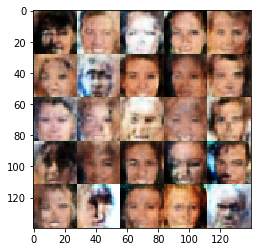

Epoch 1/1... Discriminator loss: 1.3529 Generator loss: 0.8276
Epoch 1/1... Discriminator loss: 1.4279 Generator loss: 0.7271
Epoch 1/1... Discriminator loss: 1.3907 Generator loss: 0.7459
Epoch 1/1... Discriminator loss: 1.3957 Generator loss: 0.7484
Epoch 1/1... Discriminator loss: 1.3689 Generator loss: 0.7836
Epoch 1/1... Discriminator loss: 1.3640 Generator loss: 0.8407
Epoch 1/1... Discriminator loss: 1.3185 Generator loss: 0.8761
Epoch 1/1... Discriminator loss: 1.4356 Generator loss: 0.7932
Epoch 1/1... Discriminator loss: 1.3849 Generator loss: 0.8093
Epoch 1/1... Discriminator loss: 1.3331 Generator loss: 0.7963


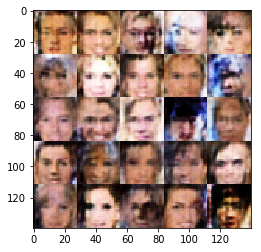

Epoch 1/1... Discriminator loss: 1.4537 Generator loss: 0.8087
Epoch 1/1... Discriminator loss: 1.3741 Generator loss: 0.8123
Epoch 1/1... Discriminator loss: 1.4040 Generator loss: 0.7930
Epoch 1/1... Discriminator loss: 1.3724 Generator loss: 0.8463
Epoch 1/1... Discriminator loss: 1.4112 Generator loss: 0.8832
Epoch 1/1... Discriminator loss: 1.3955 Generator loss: 0.7973
Epoch 1/1... Discriminator loss: 1.3925 Generator loss: 0.7662
Epoch 1/1... Discriminator loss: 1.3742 Generator loss: 0.7974
Epoch 1/1... Discriminator loss: 1.3666 Generator loss: 0.8489
Epoch 1/1... Discriminator loss: 1.3353 Generator loss: 0.7643


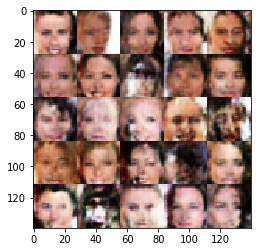

Epoch 1/1... Discriminator loss: 1.3400 Generator loss: 0.7726
Epoch 1/1... Discriminator loss: 1.3919 Generator loss: 0.8015
Epoch 1/1... Discriminator loss: 1.3803 Generator loss: 0.7802
Epoch 1/1... Discriminator loss: 1.4294 Generator loss: 0.7688
Epoch 1/1... Discriminator loss: 1.3595 Generator loss: 0.7643
Epoch 1/1... Discriminator loss: 1.3322 Generator loss: 0.8344
Epoch 1/1... Discriminator loss: 1.3848 Generator loss: 0.8466
Epoch 1/1... Discriminator loss: 1.3894 Generator loss: 0.8346
Epoch 1/1... Discriminator loss: 1.3950 Generator loss: 0.8056
Epoch 1/1... Discriminator loss: 1.4177 Generator loss: 0.8081


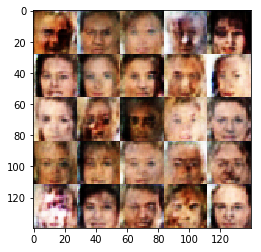

Epoch 1/1... Discriminator loss: 1.4121 Generator loss: 0.9005
Epoch 1/1... Discriminator loss: 1.3985 Generator loss: 0.8370
Epoch 1/1... Discriminator loss: 1.4319 Generator loss: 0.8479
Epoch 1/1... Discriminator loss: 1.3850 Generator loss: 0.8207
Epoch 1/1... Discriminator loss: 1.4166 Generator loss: 0.7356
Epoch 1/1... Discriminator loss: 1.3734 Generator loss: 0.8199
Epoch 1/1... Discriminator loss: 1.4165 Generator loss: 0.8429
Epoch 1/1... Discriminator loss: 1.3499 Generator loss: 0.8215
Epoch 1/1... Discriminator loss: 1.3172 Generator loss: 0.9872
Epoch 1/1... Discriminator loss: 1.4522 Generator loss: 0.7542


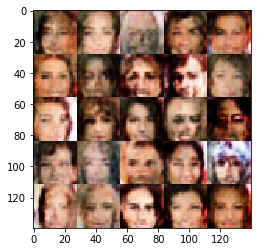

Epoch 1/1... Discriminator loss: 1.4480 Generator loss: 0.8107
Epoch 1/1... Discriminator loss: 1.3120 Generator loss: 0.6917
Epoch 1/1... Discriminator loss: 1.4363 Generator loss: 0.6601
Epoch 1/1... Discriminator loss: 1.3474 Generator loss: 0.9569
Epoch 1/1... Discriminator loss: 1.3489 Generator loss: 0.7501
Epoch 1/1... Discriminator loss: 1.3872 Generator loss: 0.7828
Epoch 1/1... Discriminator loss: 1.4159 Generator loss: 0.7955
Epoch 1/1... Discriminator loss: 1.3958 Generator loss: 0.8401
Epoch 1/1... Discriminator loss: 1.4744 Generator loss: 0.7750
Epoch 1/1... Discriminator loss: 1.3444 Generator loss: 0.8190


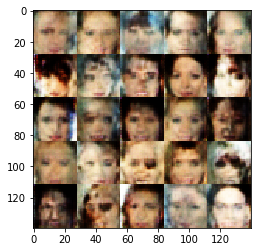

Epoch 1/1... Discriminator loss: 1.3471 Generator loss: 0.7901
Epoch 1/1... Discriminator loss: 1.3157 Generator loss: 0.8199
Epoch 1/1... Discriminator loss: 1.3838 Generator loss: 0.7458
Epoch 1/1... Discriminator loss: 1.4334 Generator loss: 0.7563
Epoch 1/1... Discriminator loss: 1.4641 Generator loss: 0.8571
Epoch 1/1... Discriminator loss: 1.4277 Generator loss: 0.7455
Epoch 1/1... Discriminator loss: 1.3328 Generator loss: 0.7923
Epoch 1/1... Discriminator loss: 1.3527 Generator loss: 0.7280
Epoch 1/1... Discriminator loss: 1.4551 Generator loss: 0.8653
Epoch 1/1... Discriminator loss: 1.3883 Generator loss: 0.7993


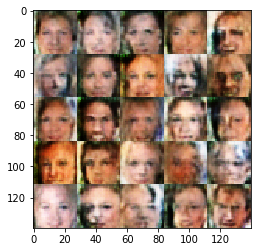

Epoch 1/1... Discriminator loss: 1.4315 Generator loss: 0.8526
Epoch 1/1... Discriminator loss: 1.3794 Generator loss: 0.9195
Epoch 1/1... Discriminator loss: 1.3781 Generator loss: 0.7455
Epoch 1/1... Discriminator loss: 1.4062 Generator loss: 0.7908
Epoch 1/1... Discriminator loss: 1.3618 Generator loss: 0.8117
Epoch 1/1... Discriminator loss: 1.3825 Generator loss: 0.7386
Epoch 1/1... Discriminator loss: 1.3624 Generator loss: 0.8649
Epoch 1/1... Discriminator loss: 1.4254 Generator loss: 0.9569
Epoch 1/1... Discriminator loss: 1.4101 Generator loss: 0.8087
Epoch 1/1... Discriminator loss: 1.4290 Generator loss: 0.7897


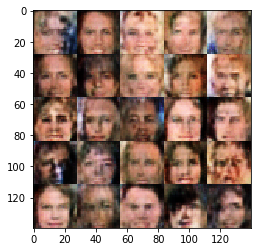

Epoch 1/1... Discriminator loss: 1.3623 Generator loss: 0.7731
Epoch 1/1... Discriminator loss: 1.4071 Generator loss: 0.7348
Epoch 1/1... Discriminator loss: 1.3967 Generator loss: 0.7705
Complete training!


In [44]:
batch_size = 32
z_dim = 100
learning_rate = (0.0001, 0.0004)
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.